### Load Dependencies

In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
import cv2
from skimage import filters, measure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from scipy.signal import convolve2d
from scipy.spatial import KDTree
import seaborn as sns
import pickle
import librosa as lb
import time
import cProfile
import os
import os.path
import pyximport; pyximport.install()
import multiprocessing
from ExtractBootlegFeatures import *

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


### Cython DTW

In [3]:
dtw_steps = [1,1,1,2,2,1] # dtw
dtw_weights = [1,1,2]

In [4]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

import sys
import time


DTYPE_INT32 = np.int32
ctypedef np.int32_t DTYPE_INT32_t

DTYPE_FLOAT = np.float64
ctypedef np.float64_t DTYPE_FLOAT_t

cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_Cost_To_AccumCostAndSteps(Cin, parameter):
    '''
    Inputs
        C: The cost Matrix
    '''


    '''
    Section for checking and catching errors in the inputs
    '''

    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
    try:
        C = np.array(Cin, dtype=DTYPE_FLOAT)
    except TypeError:
        print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
        return [-1, -1, -1]
    except ValueError:
        print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
        return [-1, -1, -1]

    cdef np.ndarray[np.uint32_t, ndim=1] dn
    cdef np.ndarray[np.uint32_t, ndim=1] dm
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
    # make sure dn, dm, and dw are setup
    # dn loading and exception handling
    if ('dn'  in parameter.keys()):
        try:

            dn = np.array(parameter['dn'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dn = np.array([1, 1, 0], dtype=np.uint32)
    # dm loading and exception handling
    if 'dm'  in parameter.keys():
        try:
            dm = np.array(parameter['dm'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
        dm = np.array([1, 0, 1], dtype=np.uint32)
    # dw loading and exception handling
    if 'dw'  in parameter.keys():
        try:
            dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
        print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)

    
    '''
    Section where types are given to the variables we're going to use 
    '''
    # create matrices to store our results (D and E)
    cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
    cdef DTYPE_INT32_t numCols = C.shape[1]
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)

    cdef unsigned int maxRowStep = max(dn)
    cdef unsigned int maxColStep = max(dm)

    cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

    cdef DTYPE_FLOAT_t bestCost
    cdef DTYPE_INT32_t bestCostIndex
    cdef DTYPE_FLOAT_t costForStep
    cdef unsigned int row, col
    cdef unsigned int stepIndex

    '''
    The start of the actual algorithm, now that all our variables are set up
    '''
    # initializing the cost matrix - depends on whether its subsequence DTW
    # essentially allow us to hop on the bottom anywhere (so could start partway through one of the signals)
    if parameter['SubSequence']:
        for col in range(numCols):
            accumCost[maxRowStep, col + maxColStep] = C[0, col]
    else:
        accumCost[maxRowStep, maxColStep] = C[0,0]

    # filling the accumulated cost matrix
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
            bestCostIndex = 0
            # go through each step, find the best one
            for stepIndex in range(numDifSteps):
                #costForStep = accumCost[<unsigned int>(row - dn[<unsigned int>(stepIndex)]), <unsigned int>(col - dm[<unsigned int>(stepIndex)])] + dw[<unsigned int>(stepIndex)] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # save the best cost and best cost index
            accumCost[row, col] = bestCost
            steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex

    # return the accumulated cost along with the matrix of steps taken to achieve that cost
    return [accumCost[maxRowStep:, maxColStep:], steps]

@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
    '''

    Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
    '''

    cdef np.ndarray[unsigned int, ndim=1] dn
    cdef np.ndarray[unsigned int, ndim=1] dm
    cdef np.uint8_t subseq
    # make sure dn, dm, and dw are setup
    if ('dn'  in parameter.keys()):
        dn = parameter['dn']
    else:
        dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
    if 'dm'  in parameter.keys():
        dm = parameter['dm']
    else:
        dm = np.array([1, 0, 1], dtype=DTYPE_INT32)
    if 'SubSequence' in parameter.keys():
        subseq = parameter['SubSequence']
    else:
        subseq = 0

    cdef np.uint32_t numRows
    cdef np.uint32_t numCols
    cdef np.uint32_t curRow
    cdef np.uint32_t curCol
    cdef np.uint32_t endCol
    cdef DTYPE_FLOAT_t endCost

    numRows = accumCost.shape[0]
    numCols = accumCost.shape[1]

    # either start at the far corner (non sub-sequence)
    # or start at the lowest cost entry in the last row (sub-sequence)
    # where all of the signal along the row has been used, but only a 
    # sub-sequence of the signal along the columns has to be used
    curRow = numRows - 1
    if subseq:
        curCol = np.argmin(accumCost[numRows - 1, :])
    else:
        curCol = numCols - 1

    endCol = curCol
    endCost = accumCost[curRow, curCol]

    cdef np.uint32_t curRowStep
    cdef np.uint32_t curColStep
    cdef np.uint32_t curStepIndex


    cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol

    cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
    cdef np.uint32_t stepIndex = 0
    cdef np.int8_t done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)
    while not done:
        if accumCost[curRow, curCol] == MAX_FLOAT:
            print('A path is not possible')
            break

        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = stepsForCost[curRow, curCol]
        curRowStep = dn[curStepIndex]
        curColStep = dm[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)

    # reverse the path (a matrix with two rows) and return it
    return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [5]:
def alignBootlegScores(query, ref, numRefNotes, steps = [1,1,1,2,2,1], weights = [1,1,2], optimized=True):
    if optimized: # Cython implementation
        # set params
        assert len(steps) % 2 == 0, "The length of steps must be even."
        dn = np.array(steps[::2], dtype=np.uint32)
        dm = np.array(steps[1::2], dtype=np.uint32)
        dw = weights
        subsequence = True
        parameter = {'dn': dn, 'dm': dm, 'dw': dw, 'SubSequence': subsequence}

        # Compute cost matrix
        #cost = costMetric(query.T, ref)
        numQueryNotes = np.sum(query, axis=0)
        cost = normalizedCostMetric(query, ref, numQueryNotes, numRefNotes)

        # DTW
        [D, s] = DTW_Cost_To_AccumCostAndSteps(cost, parameter)
        [wp, endCol, endCost] = DTW_GetPath(D, s, parameter)

        # Reformat the output
        wp = wp.T[::-1]
    else: # librosa implementation
        steps = np.array(steps).reshape((-1,2))
        D, wp = lb.sequence.dtw(query, ref, step_sizes_sigma = steps, weights_mul = weights, subseq = True, metric = costMetric)
    return D, wp

### Get Bootleg Query Image

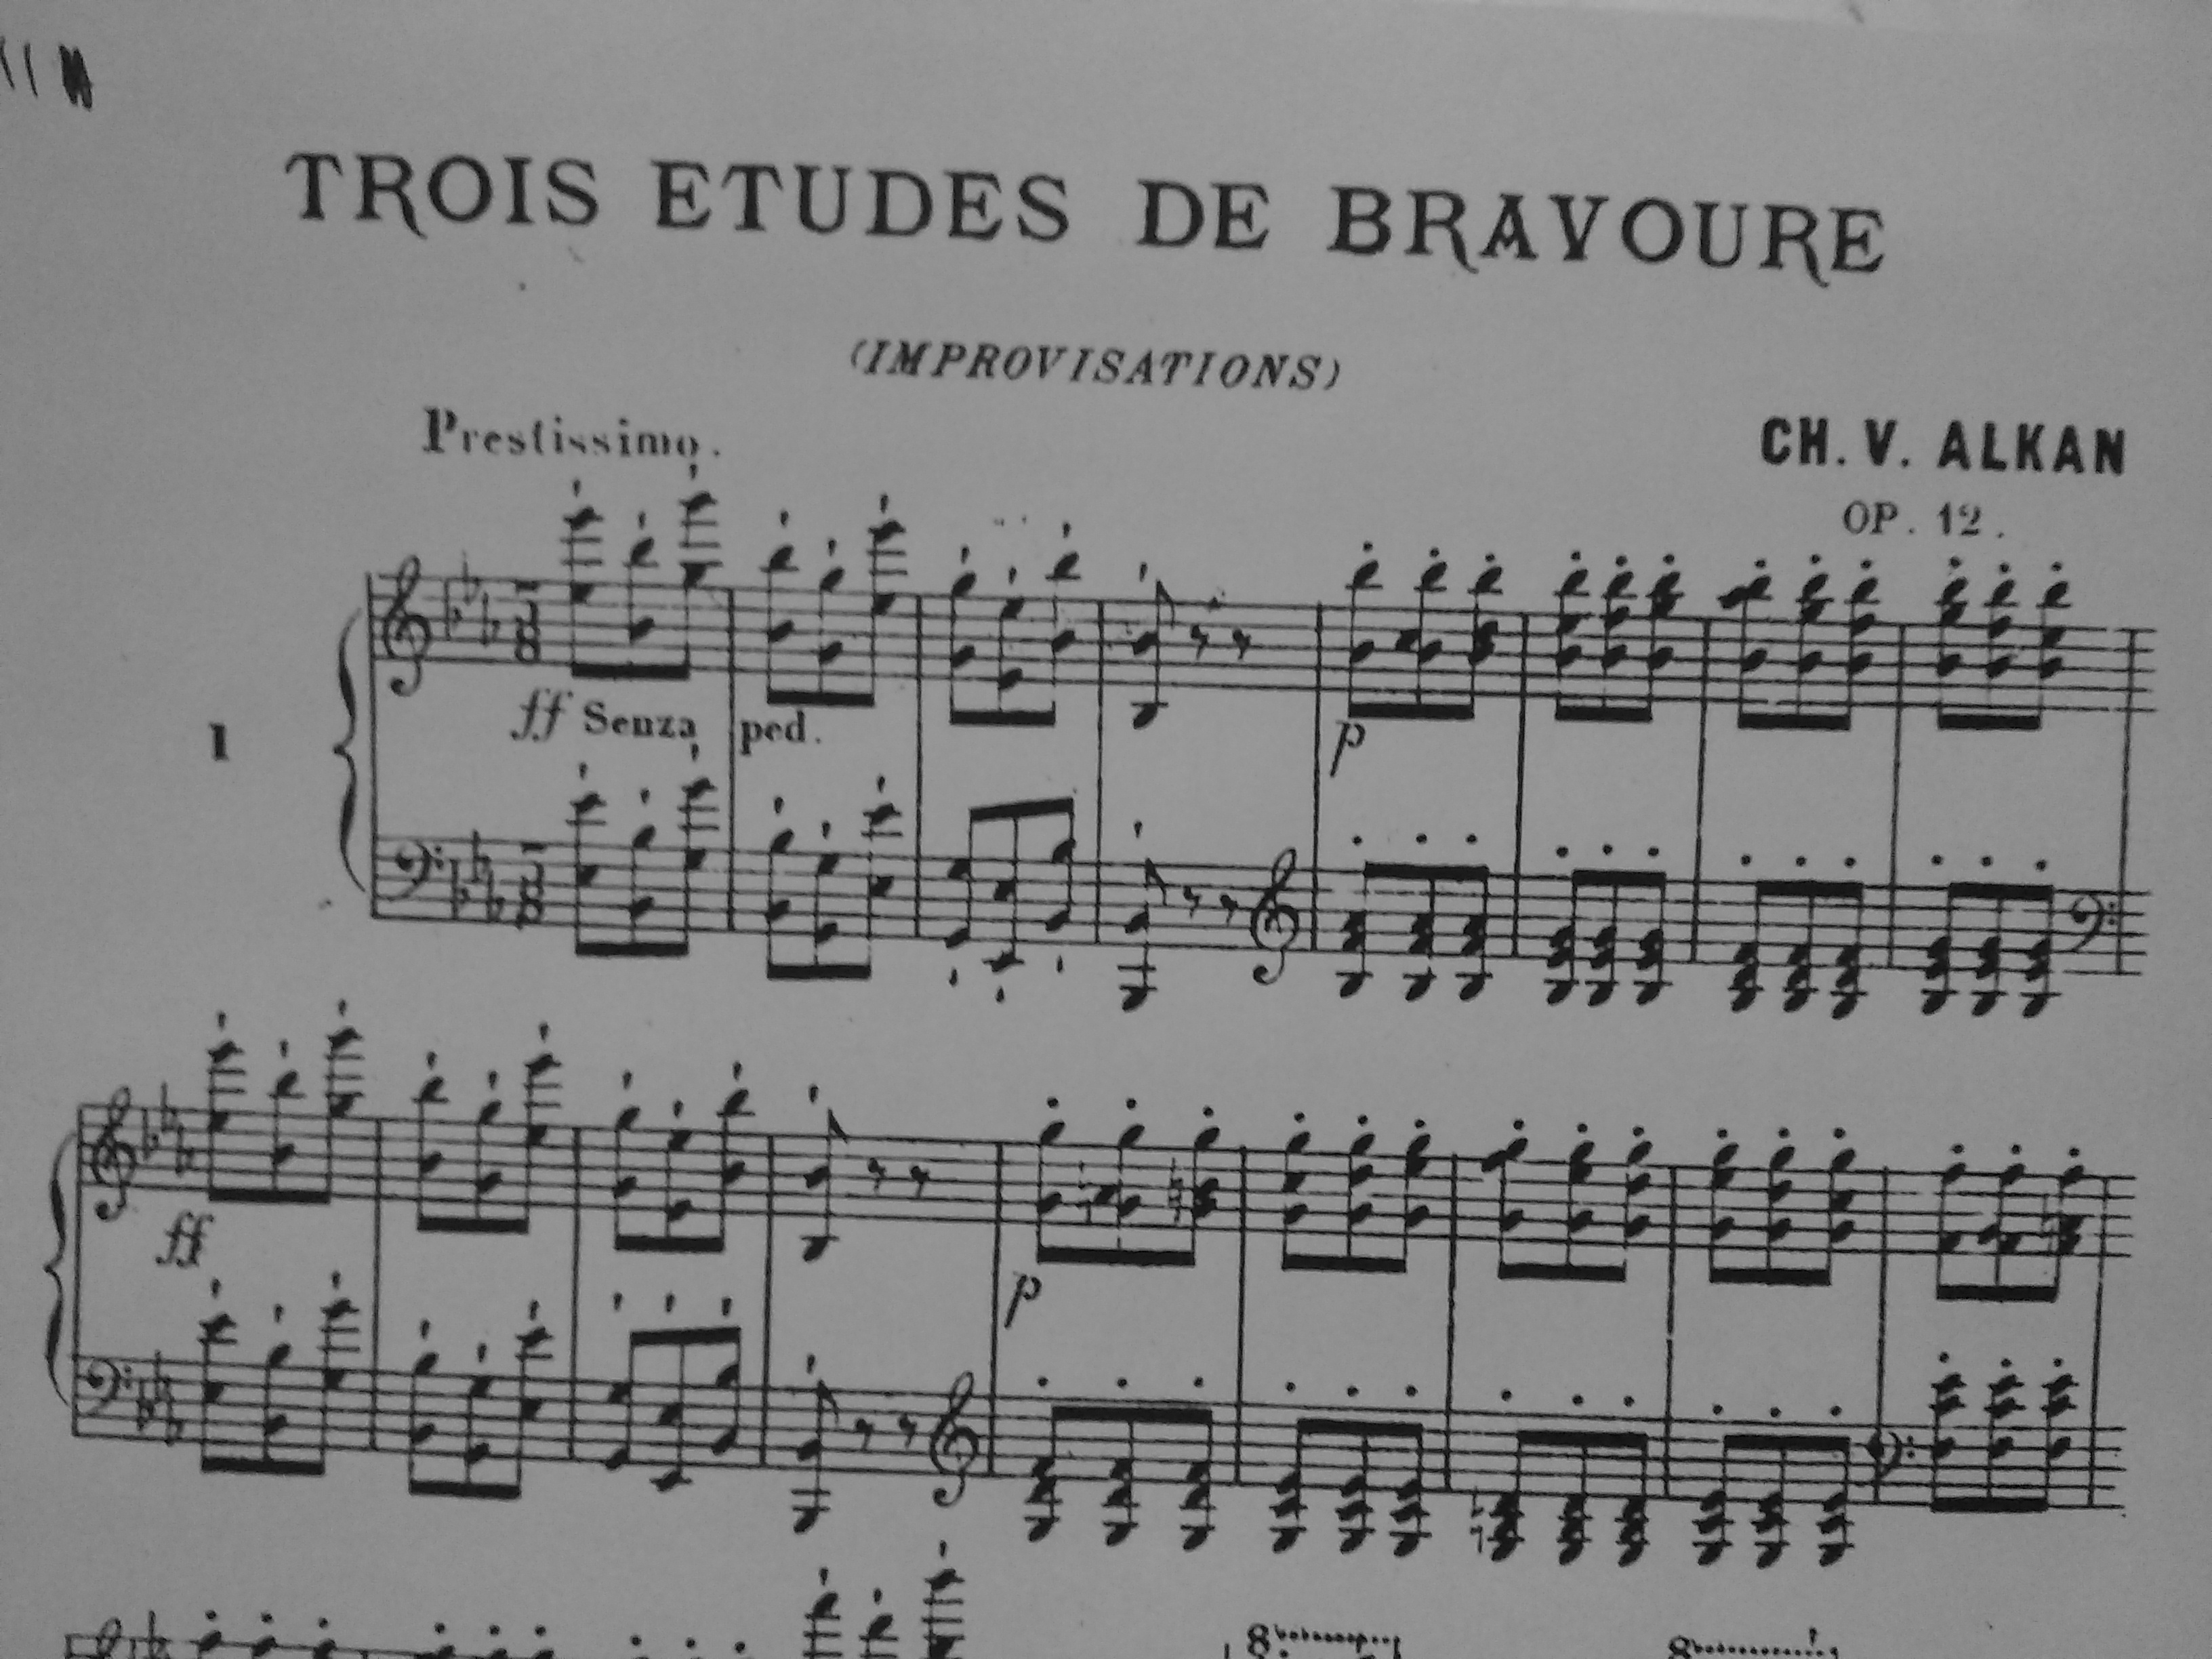

In [6]:
imagefile = 'data/queries/p111_q1.jpg'
pim1 = Image.open(imagefile).convert('L')
pim1

Processing data/queries/p111_q1.jpg


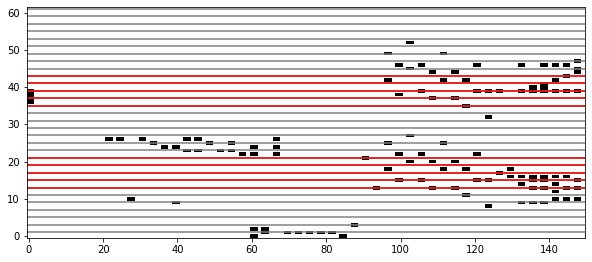

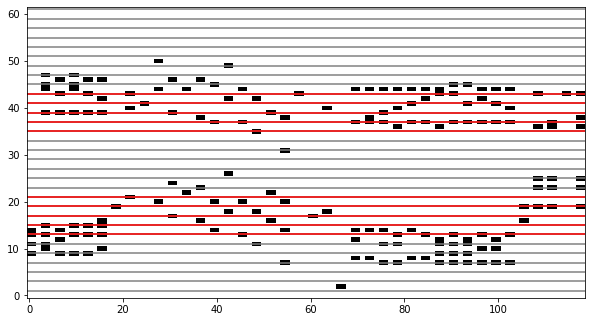

In [7]:
bscore_query=processQuery(imagefile)
visualizeLongBootlegScore(bscore_query, [13,15,17,19,21,35,37,39,41,43])

### Load Reverse Index

In [8]:
pickle_file = 'experiments/allBootlegScores-c/index500.pkl'
with open(pickle_file, 'rb') as f:
    rindex = pickle.load(f)

### Generate Histograms

In [9]:
def bootlegHash(arr):
    bitstring = ""
    for i in range(len(arr)):
        if arr[i]==1:
            bitstring+="1"
        else:
            bitstring +="0"
    bitstring = bitstring+"00"
    hashint = int(bitstring, 2)
    hashint = np.uint64(hashint)
    return hashint

In [10]:
def showHistograms(arr,numBins):
    plt.hist(arr, normed=False, bins=numBins)
    plt.show()

In [11]:
def getOffsetDelta(bscore_query):
    offsetDict = {}
    for index in range(len(bscore_query.T)):
        hashkey = bootlegHash(bscore_query.T[index])
        if hashkey ==0 or not hashkey in rindex:
            continue
        rindex_hash = rindex[hashkey]
        for key in rindex_hash:
            offset = np.array(rindex_hash[key])-index
            if key in offsetDict:
                offsetDict[key] = np.concatenate((offsetDict[key],offset))
            else:
                offsetDict[key]=offset
    return offsetDict

In [12]:
def rankHistograms(offsetDict, bin_size=10):
    histograms = {}
    bin_size = 10
    pieceScores = []
    numShow = 5
    for key in offsetDict:
        h = offsetDict[key]
        r = np.max(h)-np.min(h)
        numBins = int(r/bin_size)
        if numBins == 0 or h == []:
            pieceScores.append((key, 0))
            continue
        heights,_ = np.histogram(h, bins=numBins)
        histograms[key]=(h,numBins)
        score = np.max(heights)
        pieceScores.append((key, score))
    pieceScores = sorted(pieceScores, key = lambda x:x[1], reverse=True)
    return pieceScores, histograms

In [13]:
offsetDict = getOffsetDelta(bscore_query)
pieceScores, histograms = rankHistograms(offsetDict)

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


In [14]:
def displayHist(pieceScores, pieceNum):
    pieceScores1 = sorted(pieceScores, key = lambda x:int(x[0][1:]))
    print(pieceScores1[pieceNum-1][0])
    h,numBins = histograms[pieceScores1[pieceNum-1][0]]
    showHistograms(h,numBins)

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


('p778', 61)
('p3190', 54)
('p4366', 53)
('p4918', 51)
('p4794', 47)


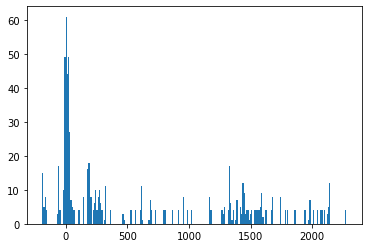

p1


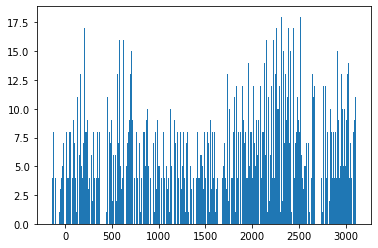

In [15]:
for i in range(5):
    print(pieceScores[i])
h,numBins = histograms[pieceScores[0][0]]
showHistograms(h,numBins)

displayHist(pieceScores, 1)

In [16]:
pieceStr = pieceScores[0][0]
midi_db_dir = 'experiments/train/db'
midi_bscore_pkl = '{}/{}.pkl'.format(midi_db_dir,pieceStr)
if not os.path.exists(midi_bscore_pkl):
    midi_bscore_pkl = '{}/{}.pkl'.format(midi_db_dir,'p171')
midi_d = loadMidiBootlegScore(midi_bscore_pkl)

bscore_midi, miditimes, num_notes, stafflines = loadMidiBootlegScore(midi_bscore_pkl)
D, wp = alignBootlegScores(bscore_query, bscore_midi, num_notes, dtw_steps, dtw_weights)
matchSegmentTime, matchSegmentTick = getPredictedTimestamps(wp, miditimes)

In [17]:
def getRank(pieceScores,correctPiece):
    rank = 200
    for i in range(len(pieceScores)):
        if pieceScores[i][0]==correctPiece:
            rank=i+1
    return rank

In [18]:
getRank(pieceScores, os.path.basename(imagefile).split('_')[0])

345

### Run system on all files

In [19]:
def processSingleQuery(imagefile, midi_bscore_pkl_path, rindex, outfile = None):
    profileStart = time.time()
    
    # Parameters
    dtw_steps = [1,1,1,2,2,1] 
    dtw_weights = [1,1,2]
    
    # Get Bootleg Score
    bscore_query=processQuery(imagefile)
    
    # Generate and rank histograms
    offsetDict = getOffsetDelta(bscore_query)
    pieceScores, histograms = rankHistograms(offsetDict)
    
    # Generate Midi bootleg score
    if len(pieceScores)==0:
        profileEnd = time.time()
        profileDur = profileEnd - profileStart
        saveToFile(outfile, imagefile, ((0,0), 200), profileDur)
        return (0,0), profileDur
    pieceStr = pieceScores[0][0]
    midi_bscore_pkl = '{}/{}.pkl'.format(midi_bscore_pkl_path, pieceStr)
    
    if not os.path.exists(midi_bscore_pkl):
        midi_bscore_pkl = '{}/{}.pkl'.format(midi_bscore_pkl_path, 'p171')
        
    midi_d = loadMidiBootlegScore(midi_bscore_pkl)
    bscore_midi, miditimes, num_notes, stafflines = loadMidiBootlegScore(midi_bscore_pkl)
    
    # Align bootleg scores
    D, wp = alignBootlegScores(bscore_query, bscore_midi, num_notes, dtw_steps, dtw_weights)
    matchSegmentTime, matchSegmentTick = getPredictedTimestamps(wp, miditimes)
    
    profileEnd = time.time()
    
    # Evaluate Rank
    correctPiece = os.path.basename(imagefile).split('_')[0]
    rank = getRank(pieceScores,correctPiece)
    
    # Profile & save to file
    profileDur = profileEnd - profileStart
    saveToFile(outfile, imagefile, (matchSegmentTime, rank), profileDur)
    print(matchSegmentTime, rank,profileDur)
    return matchSegmentTime, rank

In [20]:
def saveToFile(outfile, imagefile, segment, dur):
    if outfile:
        with open(outfile, 'w') as f:
            query = os.path.splitext(os.path.basename(imagefile))[0]
            outStr = "{},{:.2f},{:.2f},{:d},{:.2f}\n".format(query, segment[0][0], segment[0][1], int(segment[1]), dur)
            f.write(outStr)

In [21]:
# process single query
st = time.time()
pickle_file = 'experiments/allBootlegScores-c/index2000.pkl'
with open(pickle_file, 'rb') as f:
    rindex = pickle.load(f)
query_file = 'data/queries/p123_q1.jpg'
midi_bscore_path = 'experiments/Train1000/db/'
matchTimes,rank = processSingleQuery(query_file, midi_bscore_path,rindex)
print(matchTimes,rank)
print("Total Time: ",time.time()-st)
#cProfile.run("processQuery(query_file, midi_bscore_file)") # for profiling

Processing data/queries/p123_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(75.03295500000002, 87.40219100000002) 1 5.4993627071380615
(75.03295500000002, 87.40219100000002) 1
Total Time:  8.19472050666809


In [22]:
def processQuery_wrapper(queryfile, mididir, rindex, outdir):
    # wrapper for running multiple jobs in parallel
    basename = os.path.splitext(os.path.basename(queryfile))[0] # e.g. p1_q1
    hyp_outfile = "{}/{}.hyp".format(outdir, basename)
    piece = basename.split('_')[0]
    return processSingleQuery(queryfile, mididir, rindex, hyp_outfile)

In [26]:
# process all queries
pickle_file = 'experiments/allBootlegScores-c/index200.pkl'
query_list = 'cfg_files/query.test.list' # list of query images
midi_bs_dir = 'experiments/test/db' # directory containing midi bootleg scores
outdir = 'experiments/t200-2/hyp' # where to save hypothesis output files

# prep output directory
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# load reverse index
with open(pickle_file, 'rb') as f:
    rindex = pickle.load(f)

# number of cores to use
n_cores = 32 #multiprocessing.cpu_count()

# prep inputs for parallelization
inputs = []
with open(query_list, 'r') as f:
    for line in f:
        inputs.append((line.rstrip(), midi_bs_dir, rindex, outdir))
for i in inputs:
    processQuery_wrapper(i[0],i[1],i[2],i[3])
    
# process queries in parallel
#
#outputs = list(pool.starmap(processQuery_wrapper, inputs))

Processing data/queries/p2_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 27.000072) 1 1.2952868938446045
Processing data/queries/p2_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 40.500108000000004) 1 1.349909782409668
Processing data/queries/p2_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(28.404763245833333, 64.12517100000001) 1 1.3485960960388184
Processing data/queries/p2_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(54.623583162500005, 81.00021600000001) 1 1.2933838367462158
Processing data/queries/p2_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(13.875037, 54.000144) 1 1.3220758438110352
Processing data/queries/p2_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(40.875109, 81.750218) 1 1.37965989112854
Processing data/queries/p2_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(81.18771650000001, 108.000288) 1 1.2877094745635986
Processing data/queries/p2_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(99.375265, 135.375361) 1 1.4070310592651367
Processing data/queries/p2_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(81.375217, 121.6878245) 1 1.3472001552581787
Processing data/queries/p2_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(108.000288, 141.5628775) 1 1.3316254615783691
Processing data/queries/p3_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.00181080625, 36.24124120833333) 1 1.546783447265625
Processing data/queries/p3_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(18.835891500000002, 38.47251850000001) 8 1.6849749088287354
Processing data/queries/p3_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(123.79687027500002, 143.56743964999987) 1 1.6599617004394531
Processing data/queries/p3_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(168.584568775, 203.23920410833347) 1 1.5190954208374023
Processing data/queries/p3_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(203.00383610833347, 220.75774185833356) 1 1.4827442169189453
Processing data/queries/p3_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(220.60082985833355, 251.74588344166696) 1 1.4969887733459473
Processing data/queries/p3_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(349.3135669000002, 365.06097216666643) 1 1.620060682296753
Processing data/queries/p3_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(365.7722386249998, 389.9490936020835) 1 1.6792709827423096
Processing data/queries/p3_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(438.37511376875085, 471.11414551875083) 1 1.7156476974487305
Processing data/queries/p3_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(484.3827496020843, 497.45157972708415) 1 1.7494168281555176
Processing data/queries/p4_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(354.6361518583335, 372.39098177500017) 69 1.624744176864624
Processing data/queries/p4_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(398.77583174166705, 411.12346820000045) 86 1.6713378429412842
Processing data/queries/p4_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(376.342327491667, 392.3132851166671) 56 1.6781456470489502
Processing data/queries/p4_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(355.5831218583335, 368.81017460833357) 81 1.3864526748657227
Processing data/queries/p4_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(653.281464977083, 690.6736144770829) 41 1.5871222019195557
Processing data/queries/p4_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(408.3655071249999, 465.3847549999999) 20 1.547203540802002
Processing data/queries/p4_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(352.6689378583335, 369.77021560833356) 86 1.7025911808013916
Processing data/queries/p4_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(398.5289587416671, 417.1866381916671) 63 1.58250093460083
Processing data/queries/p4_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(142.30773499999998, 157.17953433333332) 104 1.4958322048187256
Processing data/queries/p4_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(78.64530875, 95.16146874999998) 70 1.849886178970337
Processing data/queries/p6_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 10.848747995833333) 1 1.7682769298553467
Processing data/queries/p6_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(3.5987529958333333, 12.911246995833334) 1 1.6809308528900146
Processing data/queries/p6_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(7.682084495833333, 15.161246995833334) 1 1.642082929611206
Processing data/queries/p6_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(18.7846835, 29.19015175208333) 1 1.5869321823120117
Processing data/queries/p6_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(22.25265175208333, 32.47140175208333) 1 1.5203828811645508
Processing data/queries/p6_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(32.28390175208333, 43.81515175208334) 1 1.5133447647094727
Processing data/queries/p6_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(74.60378125208334, 85.94201675208333) 1 1.6536600589752197
Processing data/queries/p6_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(57.03390175208334, 68.25082525208333) 1 1.723343849182129
Processing data/queries/p6_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(61.72140175208334, 71.42730325208333) 1 1.6584086418151855
Processing data/queries/p6_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(74.60378125208334, 85.94201675208333) 1 1.5555858612060547
Processing data/queries/p7_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 41.026893333333334) 1 1.5256092548370361
Processing data/queries/p7_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(11.799166666666668, 41.026893333333334) 1 1.2808754444122314
Processing data/queries/p7_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(24.79915666666667, 53.42689333333334) 1 1.300290584564209
Processing data/queries/p7_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(52.22689333333334, 92.63986823958334) 1 1.6238958835601807
Processing data/queries/p7_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(65.23568333333333, 104.01489323958334) 1 1.5177624225616455
Processing data/queries/p7_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(80.09722333333333, 116.01489323958334) 1 1.5100452899932861
Processing data/queries/p7_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(115.41489323958335, 150.99378923958335) 1 1.444514513015747
Processing data/queries/p7_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(138.81489323958334, 171.48645523958336) 1 1.3722453117370605
Processing data/queries/p7_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(171.48645523958336, 194.63648923958337) 1 1.2209346294403076
Processing data/queries/p7_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(193.83648923958336, 235.30608385208336) 1 1.355571985244751
Processing data/queries/p8_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 24.801776583333332) 1 1.6379265785217285
Processing data/queries/p8_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(16.35859125, 41.430572) 1 1.528580665588379
Processing data/queries/p8_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(47.56693849999999, 61.877550166666666) 1 1.7050070762634277
Processing data/queries/p8_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(65.79800654166667, 78.3832396875) 1 1.7152953147888184
Processing data/queries/p8_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(70.05937216666666, 82.559378) 1 1.5637686252593994
Processing data/queries/p8_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(117.38710233333333, 130.9526335375) 1 1.828970193862915
Processing data/queries/p8_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(130.6193002875, 142.9526305375) 1 1.9793939590454102
Processing data/queries/p8_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(161.81373693333333, 174.93040032083334) 1 1.642822027206421
Processing data/queries/p8_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(165.56373599583333, 183.31373162083335) 1 1.8596243858337402
Processing data/queries/p8_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(200.01140162083337, 218.35030195416672) 1 1.4051198959350586
Processing data/queries/p9_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(243.809536, 275.238109) 6 1.4464962482452393
Processing data/queries/p9_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(6.847436000000001, 37.70920975000001) 1 1.6072132587432861
Processing data/queries/p9_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(17.956971999999997, 42.497349375) 1 1.435887336730957
Processing data/queries/p9_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(28.977143000000005, 42.497349375) 1 1.316650390625
Processing data/queries/p9_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(50.644223472916664, 69.01144938541665) 1 1.520005702972412
Processing data/queries/p9_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(114.72056888541664, 127.64327263125) 1 1.4052448272705078
Processing data/queries/p9_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(154.69658347083333, 171.80144072083326) 53 1.72784423828125
Processing data/queries/p9_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(181.91482288125013, 214.44282531250016) 1 1.6909563541412354
Processing data/queries/p9_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(200.16840938125011, 222.34501935000017) 1 1.9701087474822998
Processing data/queries/p9_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(214.10806450937517, 229.53295735000017) 1 1.651458740234375
Processing data/queries/p10_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(14.7619055, 59.047622) 1 1.457777738571167
Processing data/queries/p10_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(30.476192, 75.47619424999999) 1 1.2822396755218506
Processing data/queries/p10_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(129.523816, 165.39683366666665) 1 1.5239427089691162
Processing data/queries/p10_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(144.44445166666665, 177.142866) 1 1.8747625350952148
Processing data/queries/p10_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(110.0000055, 155.39683316666668) 1 1.8783955574035645
Processing data/queries/p10_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(205.39683566666668, 247.30159966666668) 1 1.7270305156707764
Processing data/queries/p10_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(220.79366183333332, 258.80953675) 1 1.642164707183838
Processing data/queries/p10_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(236.03175783333333, 275.238109) 1 1.7707016468048096
Processing data/queries/p10_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(247.46032983333333, 275.238109) 1 1.5469870567321777
Processing data/queries/p10_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(45.2380975, 88.0952425) 1 1.516392707824707
Processing data/queries/p12_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 37.93856099999998) 1 1.4097726345062256
Processing data/queries/p12_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 54.157576289583325) 1 1.636530876159668
Processing data/queries/p12_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(37.93856099999998, 74.12074630208332) 1 2.1352522373199463
Processing data/queries/p12_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(53.32286441458333, 84.38211745208334) 1 1.8375935554504395
Processing data/queries/p12_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(66.30778267708332, 85.44878445208333) 1 1.3522462844848633
Processing data/queries/p12_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(85.44878445208333, 131.73485643749999) 1 1.6389732360839844
Processing data/queries/p12_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(107.77466557604166, 139.53012293749995) 1 1.8405187129974365
Processing data/queries/p12_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(119.4779144020833, 150.84255771249994) 1 1.6424572467803955
Processing data/queries/p12_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(131.8609068125, 172.33668171249988) 1 1.535008192062378
Processing data/queries/p12_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(139.53012293749995, 172.33668171249988) 1 1.3724229335784912
Processing data/queries/p13_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.000757575, 31.026653) 1 1.868178367614746
Processing data/queries/p13_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(20.150184499999995, 49.821480375) 1 2.171316385269165
Processing data/queries/p13_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(45.19404441666668, 60.451968120833335) 1 1.9641706943511963
Processing data/queries/p13_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(1.090908, 19.786548499999995) 1 1.6178078651428223
Processing data/queries/p13_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(70.5248417041667, 99.24559095416672) 1 1.7770216464996338
Processing data/queries/p13_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(37.7380595, 62.548655749999995) 15 2.030388832092285
Processing data/queries/p13_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(109.31626174583337, 130.42169237083337) 1 1.4314794540405273
Processing data/queries/p13_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(205.3189797395836, 225.79273807291682) 1 1.9006507396697998
Processing data/queries/p13_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(65.208400625, 77.6404675) 2 1.3948044776916504
Processing data/queries/p13_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(134.45182072083333, 157.22718522083335) 2 1.5719335079193115
Processing data/queries/p14_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.589623, 12.237471868750001) 1 1.4287805557250977
Processing data/queries/p14_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(6.2215229999999995, 24.86283951875) 1 1.612182378768921
Processing data/queries/p14_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(24.71009001875, 31.20540687708333) 1 1.3064157962799072
Processing data/queries/p14_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(31.20540687708333, 53.09417559999997) 1 1.858565092086792
Processing data/queries/p14_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(490.20520691666667, 501.19766741666666) 160 1.4164907932281494
Processing data/queries/p14_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(65.6378249833333, 78.82175564999996) 1 1.4000389575958252
Processing data/queries/p14_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(79.33333333333333, 81.95833333333334) 16 1.1958677768707275
Processing data/queries/p14_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(2.0303325, 8.57917775) 1 1.2236971855163574
Processing data/queries/p14_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(85.22435689999995, 97.77225932916663) 1 1.2127890586853027
Processing data/queries/p14_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(97.93787707916663, 103.28093990833331) 1 1.098884105682373
Processing data/queries/p16_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(82.432038, 110.65938600000001) 1 1.6640167236328125
Processing data/queries/p16_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(16.909136, 49.363768) 1 1.7894606590270996
Processing data/queries/p16_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(135.89747666666665, 181.28210566666664) 7 1.7709975242614746
Processing data/queries/p16_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(81.00021600000001, 107.18210400000001) 1 1.7016260623931885
Processing data/queries/p16_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(398.3438039916671, 413.43599328333374) 2 2.1149814128875732
Processing data/queries/p16_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(163.15952600000003, 183.27321600000002) 1 1.6500189304351807
Processing data/queries/p16_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(18.516163749999997, 29.87102375) 2 1.579195261001587
Processing data/queries/p16_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(212.72784000000001, 227.45515200000003) 1 1.4366455078125
Processing data/queries/p16_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(108.818472, 138.40946) 1 1.5625300407409668
Processing data/queries/p16_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(131.113986, 149.864036) 1 1.4466171264648438
Processing data/queries/p17_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 20.32873611875) 1 1.1886451244354248
Processing data/queries/p17_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 30.801363131249996) 1 1.3362393379211426
Processing data/queries/p17_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(20.54302111875, 50.25842936041668) 1 1.3055644035339355
Processing data/queries/p17_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(30.94422038125, 50.25842936041668) 1 1.1994962692260742
Processing data/queries/p17_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(57.589993395833346, 82.20187540208335) 1 1.404141902923584
Processing data/queries/p17_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(73.29649463750002, 93.7023383833333) 1 1.372645378112793
Processing data/queries/p17_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(93.7023383833333, 106.80220518958346) 1 1.293954849243164
Processing data/queries/p17_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(99.89218479583334, 120.01327794791688) 1 1.2491912841796875
Processing data/queries/p17_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(126.15650422708362, 138.30122553541696) 1 1.3563835620880127
Processing data/queries/p17_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(151.94414233541696, 189.61166429583346) 1 1.2120821475982666
Processing data/queries/p18_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 17.539370249999997) 1 1.4928395748138428
Processing data/queries/p18_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(5.9870675, 23.997419749999995) 1 1.3705494403839111
Processing data/queries/p18_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(17.539370249999997, 31.109604666666666) 1 1.2611286640167236
Processing data/queries/p18_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(30.013878166666668, 43.94544641666664) 1 1.3941309452056885
Processing data/queries/p18_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(42.83171141666664, 60.56948616666663) 1 1.5206255912780762
Processing data/queries/p18_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(78.55262166666662, 90.44491791666661) 1 1.3820607662200928
Processing data/queries/p18_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(78.87313599999996, 91.10592708333328) 1 1.3602402210235596
Processing data/queries/p18_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(91.30745124999996, 109.84273533333332) 1 1.5852081775665283
Processing data/queries/p18_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(97.36624858333329, 116.5742021666667) 1 1.548154354095459
Processing data/queries/p18_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(166.31477991875016, 185.31732896041694) 1 1.4451572895050049
Processing data/queries/p19_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.9224282916666666, 10.527032820833337) 1 1.2392570972442627
Processing data/queries/p19_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(4.800684585416668, 14.934248691666667) 1 1.3646190166473389
Processing data/queries/p19_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(10.527032820833337, 19.423409762500004) 1 1.286583662033081
Processing data/queries/p19_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(18.623045931250005, 26.99544690833334) 1 1.1976490020751953
Processing data/queries/p19_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(26.823863479166672, 37.427557231250006) 1 1.5603489875793457
Processing data/queries/p19_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(37.427557231250006, 43.431361222916706) 1 1.465285062789917
Processing data/queries/p19_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(37.55984663333334, 48.03814167916672) 1 1.4736616611480713
Processing data/queries/p19_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(40.3472901479167, 51.984113345833386) 1 1.4758968353271484
Processing data/queries/p19_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(185.032605, 197.41972499999997) 136 1.5196614265441895
Processing data/queries/p19_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(48.12112917916672, 56.32666201250006) 1 1.0743556022644043
Processing data/queries/p20_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 20.58623495416667) 1 1.1544954776763916
Processing data/queries/p20_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(20.58623495416667, 39.69838209791668) 1 1.3901958465576172
Processing data/queries/p20_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(46.89566338125001, 61.38458449583332) 1 1.5064942836761475
Processing data/queries/p20_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(53.815835906250015, 69.15794906458332) 1 1.3229782581329346
Processing data/queries/p20_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(53.815835906250015, 68.14757363958331) 1 1.3386309146881104
Processing data/queries/p20_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(70.20049839479165, 85.94154478541658) 1 1.3136887550354004
Processing data/queries/p20_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(130.50456947083333, 140.88845022083333) 161 1.6491427421569824
Processing data/queries/p20_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(16.1290625, 26.838759999999997) 29 1.4714622497558594
Processing data/queries/p20_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(12.888126916666666, 25.471319749999992) 5 1.2469370365142822
Processing data/queries/p20_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(103.40619600000002, 106.78194225) 94 1.3347392082214355
Processing data/queries/p22_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.125, 18.25) 125 1.556544303894043
Processing data/queries/p22_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(11.875, 29.875) 126 1.532689094543457
Processing data/queries/p22_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(94.75164625000002, 105.67678325000001) 121 1.429265022277832
Processing data/queries/p22_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(96.42941233333333, 137.51658091666667) 89 1.7883036136627197
Processing data/queries/p22_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(48.0, 63.82758375) 110 1.5206034183502197
Processing data/queries/p22_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(58.86206775, 80.105739) 94 1.7627050876617432
Processing data/queries/p22_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.29999950000000003, 21.44996425) 161 1.4937257766723633
Processing data/queries/p22_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(14.24997625, 35.24994125) 134 1.4470431804656982
Processing data/queries/p22_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(50.24991625, 73.04987825) 145 1.419832468032837
Processing data/queries/p22_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(56.84990525, 73.199878) 113 1.3188056945800781
Processing data/queries/p23_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(339.98337525, 348.84277287500004) 133 1.4755589962005615
Processing data/queries/p23_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 89.46238292916665) 143 1.735046148300171
Processing data/queries/p23_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(101.78427124999999, 115.53427124999999) 105 1.3916988372802734
Processing data/queries/p23_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(49.5000495, 99.375099375) 152 1.4773547649383545
Processing data/queries/p23_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(82.69719199999999, 119.308956) 138 1.6551942825317383
Processing data/queries/p23_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(10.032964250000003, 22.531129250000006) 123 1.4121012687683105
Processing data/queries/p23_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(85.46034399999999, 114.47343999999998) 86 1.5712311267852783
Processing data/queries/p23_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(153.59070172083335, 161.3982399708333) 84 1.488135814666748
Processing data/queries/p23_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(26.290894833333333, 120.81888179166661) 48 1.7413651943206787
Processing data/queries/p23_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(12.832774666666666, 34.12343024999999) 116 1.28358793258667
Processing data/queries/p24_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 13.736843250000002) 1 1.4129259586334229
Processing data/queries/p24_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 21.63158075) 1 1.6446449756622314
Processing data/queries/p24_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(5.289474125, 29.21052875) 1 1.8332934379577637
Processing data/queries/p24_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(95.56998524999999, 118.81615699999998) 40 1.7991364002227783
Processing data/queries/p24_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(315.72993555624953, 337.14110505625) 72 1.726886510848999
Processing data/queries/p24_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(65.91666666666667, 73.75) 39 1.6003022193908691
Processing data/queries/p24_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(49.5789515, 77.52632225) 1 1.8012645244598389
Processing data/queries/p24_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(57.835156500000004, 84.26116350000004) 7 1.722038745880127
Processing data/queries/p24_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(174.8390375, 204.00038249999997) 4 1.587390422821045
Processing data/queries/p24_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(88.49193525000003, 100.51831150000001) 4 1.3267428874969482
Processing data/queries/p26_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(1.4877330000000002, 15.464206083333334) 1 1.5041842460632324
Processing data/queries/p26_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(1.4877330000000002, 27.10948033333333) 1 1.7277030944824219
Processing data/queries/p26_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(141.80890799999997, 181.28250799999998) 84 2.200517177581787
Processing data/queries/p26_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(172.10489599999997, 209.01271199999996) 36 1.9596991539001465
Processing data/queries/p26_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(32.654540833333336, 66.48960525) 1 1.5780322551727295
Processing data/queries/p26_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(42.585573583333336, 66.48960525) 1 1.4074370861053467
Processing data/queries/p26_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(25.974353999999998, 71.16646974999999) 6 2.031421184539795
Processing data/queries/p26_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(94.94028958333328, 133.18326795833343) 1 1.8427352905273438
Processing data/queries/p26_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(106.0285175833333, 133.18326795833343) 1 1.8510684967041016
Processing data/queries/p26_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(132.92586645833342, 145.8946902083335) 1 1.9267089366912842
Processing data/queries/p27_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(1.7570544999999997, 27.50160690833333) 1 1.463834524154663
Processing data/queries/p27_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(1.5387774999999997, 40.878230533333344) 1 1.409101963043213
Processing data/queries/p27_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(28.040063033333332, 66.85327631666668) 1 1.715027093887329
Processing data/queries/p27_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(40.65995353333334, 80.25367160833332) 1 1.7612833976745605
Processing data/queries/p27_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(54.31411631666668, 80.03693985833331) 1 1.5547254085540771
Processing data/queries/p27_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(79.60347635833332, 102.38250310833325) 1 1.4752607345581055
Processing data/queries/p27_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(78.94201531666666, 118.60854014999987) 1 1.9342875480651855
Processing data/queries/p27_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(92.07167510833327, 141.76503281666658) 1 1.8850126266479492
Processing data/queries/p27_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(102.06476910833325, 142.37727806666658) 1 2.123750925064087
Processing data/queries/p27_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(115.12564885833324, 152.687049525) 1 1.8322010040283203
Processing data/queries/p28_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 35.5) 1 1.5355899333953857
Processing data/queries/p28_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(76.08333788541665, 112.81840388541664) 125 1.6405999660491943
Processing data/queries/p28_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(24.0, 59.5) 1 1.5097551345825195
Processing data/queries/p28_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(17.368395, 34.105211999999995) 167 1.6690092086791992
Processing data/queries/p28_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(71.75, 107.5) 1 1.3332297801971436
Processing data/queries/p28_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(84.0, 119.5) 1 1.4042811393737793
Processing data/queries/p28_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(96.0, 132.0) 1 1.351027250289917
Processing data/queries/p28_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(108.0, 143.75) 1 1.4358019828796387
Processing data/queries/p28_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(120.0, 156.0) 1 1.4584484100341797
Processing data/queries/p28_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(120.25, 156.0) 1 1.3342688083648682
Processing data/queries/p29_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(588.3303047041666, 595.6732556249999) 2 1.2390217781066895
Processing data/queries/p29_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(200.280503125, 252.37707970833327) 1 1.192396879196167
Processing data/queries/p29_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(12.475596, 63.65978149999999) 1 1.141516923904419
Processing data/queries/p29_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(589.7373564083332, 600.7694109999999) 2 1.245436429977417
Processing data/queries/p29_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(83.72403875000002, 137.9012778750001) 1 1.3815908432006836
Processing data/queries/p29_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(156.28481797083333, 164.37293772083328) 118 1.500457525253296
Processing data/queries/p29_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(123.65564883333342, 157.9414086250001) 1 1.1523847579956055
Processing data/queries/p29_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(583.8463289999999, 594.9921656770832) 2 1.1702122688293457
Processing data/queries/p29_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(585.1283806666665, 595.3847939999998) 2 1.1760010719299316
Processing data/queries/p29_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(588.4617149999999, 595.3847939999998) 2 1.1305019855499268
Processing data/queries/p30_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 12.323130333333337) 1 1.2757065296173096
Processing data/queries/p30_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 19.37183283333334) 1 1.2961995601654053
Processing data/queries/p30_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(135.11848697083332, 146.5851544708333) 3 1.3506641387939453
Processing data/queries/p30_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(36.37835250000001, 58.69128599999998) 1 1.3494904041290283
Processing data/queries/p30_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(50.11778091666666, 63.24925124999998) 1 1.2311997413635254
Processing data/queries/p30_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(63.983405932291646, 95.59011911458325) 1 1.254561424255371
Processing data/queries/p30_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(81.57952011458329, 113.25315687499995) 1 1.2523152828216553
Processing data/queries/p30_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.932272, 16.81431683333334) 1 1.1263129711151123
Processing data/queries/p30_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(30.805575500000014, 54.44809749999999) 1 1.3899295330047607
Processing data/queries/p30_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(95.32874399999999, 113.28923199999998) 29 1.1979246139526367
Processing data/queries/p32_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.428939, 25.536891208333323) 1 1.078218698501587
Processing data/queries/p32_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(15.605409708333337, 35.688831208333305) 1 1.1039471626281738
Processing data/queries/p32_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(15.605409708333337, 45.86398470833329) 1 1.1920244693756104
Processing data/queries/p32_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(22.992745208333325, 55.829611833333274) 1 1.299337387084961
Processing data/queries/p32_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(35.688831208333305, 56.03702333333327) 1 1.2062015533447266
Processing data/queries/p32_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(56.03702333333327, 75.6885858333333) 1 1.3613636493682861
Processing data/queries/p32_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(56.03702333333327, 86.57730933333332) 1 1.5453526973724365
Processing data/queries/p32_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(66.27898608333327, 96.37016662499997) 1 1.3992736339569092
Processing data/queries/p32_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(55.49781862499999, 86.74700962499998) 14 1.2554898262023926
Processing data/queries/p32_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(38.461549999999995, 85.19233324999999) 5 1.1675984859466553
Processing data/queries/p33_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(48.789798499999996, 57.986155749999995) 2 1.1910245418548584
Processing data/queries/p33_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 17.503266625000006) 1 1.3750152587890625
Processing data/queries/p33_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(3.9849359166666676, 23.655614125000007) 1 1.426934003829956
Processing data/queries/p33_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(11.444917083333337, 29.573310791666675) 1 1.5283310413360596
Processing data/queries/p33_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(17.030662166666673, 30.204268291666676) 1 1.4633147716522217
Processing data/queries/p33_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(28.972664541666674, 41.96712304166669) 1 1.2541477680206299
Processing data/queries/p33_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(29.809531291666676, 48.04988995833334) 1 1.5048091411590576
Processing data/queries/p33_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(35.798265291666674, 53.259394625000006) 1 1.3003029823303223
Processing data/queries/p33_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(40.62107654166668, 58.351570125) 1 1.2732610702514648
Processing data/queries/p33_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(165.8195023000002, 179.1273011750002) 112 1.207127332687378
Processing data/queries/p34_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(19.123224999999994, 52.19353299999997) 1 1.1197218894958496
Processing data/queries/p34_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(5.945397, 57.41880399999997) 1 1.2661056518554688
Processing data/queries/p34_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(32.31666999999999, 70.46421599999996) 1 1.2876513004302979
Processing data/queries/p34_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(65.11353199999998, 110.61460100000001) 1 1.297288179397583
Processing data/queries/p34_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(57.41880399999997, 108.63646100000001) 1 1.369326114654541
Processing data/queries/p34_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(94.006265, 121.87324400000003) 1 1.3363025188446045
Processing data/queries/p34_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(93.028004, 138.38072300000005) 1 1.3926551342010498
Processing data/queries/p34_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(104.017075, 137.72498500000003) 1 1.2967028617858887
Processing data/queries/p34_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(135.74300200000002, 165.30566441875004) 1 1.1796953678131104
Processing data/queries/p34_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(135.74300200000002, 166.77805641875005) 1 1.1599390506744385
Processing data/queries/p36_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(20.3144295, 56.198185874999986) 1 1.2716658115386963
Processing data/queries/p36_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(35.843903499999996, 55.431513749999986) 1 1.1475307941436768
Processing data/queries/p36_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(39.54311, 85.353973375) 1 1.3911292552947998
Processing data/queries/p36_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(347.0513861666666, 371.2757524083333) 2 1.2248270511627197
Processing data/queries/p36_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(85.353973375, 110.50825987499998) 1 1.0975828170776367
Processing data/queries/p36_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(105.82564387499997, 136.84354629166666) 1 1.233982801437378
Processing data/queries/p36_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(121.27782579166663, 163.85209204166668) 1 1.3372611999511719
Processing data/queries/p36_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(147.5820400416667, 177.2295785416667) 1 1.320908784866333
Processing data/queries/p36_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(170.25186654166671, 217.30915970833348) 1 1.4402804374694824
Processing data/queries/p36_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(238.07924904166688, 287.5882875416669) 1 1.2921051979064941
Processing data/queries/p37_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 14.577534500000002) 1 1.340705156326294
Processing data/queries/p37_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 21.557097000000002) 1 1.4332716464996338
Processing data/queries/p37_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(6.381033500000001, 28.325865500000003) 1 1.6032493114471436
Processing data/queries/p37_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(14.672411250000003, 33.93843714166666) 1 1.5301063060760498
Processing data/queries/p37_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(21.650788500000004, 40.55782870833336) 1 1.566939115524292
Processing data/queries/p37_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(28.144706000000003, 40.27716167500003) 1 1.5486359596252441
Processing data/queries/p37_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(85.7520822083334, 109.75766700416672) 1 1.584256887435913
Processing data/queries/p37_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(27.381187500000003, 50.4104397083334) 1 1.4163615703582764
Processing data/queries/p37_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(64.06464045833344, 87.86042470833341) 1 1.3964154720306396
Processing data/queries/p37_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(162.52742700416695, 177.687672504167) 1 1.213477373123169
Processing data/queries/p38_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(112.503988, 122.644828) 4 1.3487293720245361
Processing data/queries/p38_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(112.60962175, 127.292713) 2 1.3794527053833008
Processing data/queries/p38_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(9.876755625, 24.2957625) 2 1.418926477432251
Processing data/queries/p38_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(37.18308, 46.056315) 2 1.7348229885101318
Processing data/queries/p38_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(34.278151875, 48.8027925) 2 1.8177733421325684
Processing data/queries/p38_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(43.679555625, 60.045541) 2 1.594937801361084
Processing data/queries/p38_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(103.37359935625012, 116.33934039791689) 1 1.4353981018066406
Processing data/queries/p38_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(12.074921374999997, 24.454157875000043) 1 1.472748041152954
Processing data/queries/p38_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(34.383785625, 48.69715875) 2 1.694606065750122
Processing data/queries/p38_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(36.1231244166667, 51.72284268958343) 1 1.3644187450408936
Processing data/queries/p39_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(28.593994166666672, 53.27555820833336) 1 1.1207904815673828
Processing data/queries/p39_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 36.47213645833333) 1 1.255774736404419
Processing data/queries/p39_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(57.97801375000001, 64.60438675) 39 1.1661207675933838
Processing data/queries/p39_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(60.54958570833336, 83.85663472500006) 1 1.2685401439666748
Processing data/queries/p39_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(66.98617920833338, 96.42432562500005) 1 1.3474361896514893
Processing data/queries/p39_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(80.6331732083334, 107.72337770833337) 1 1.1809351444244385
Processing data/queries/p39_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(108.21827295833336, 126.8889121666667) 1 1.1766448020935059
Processing data/queries/p39_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(107.2362340416667, 138.10330704166668) 1 1.2863261699676514
Processing data/queries/p39_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(29.18817116666667, 61.16195570833336) 1 1.376098871231079
Processing data/queries/p39_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(115.59669604166672, 147.36866320833332) 1 1.2811658382415771
Processing data/queries/p40_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(5.528374714583335, 10.462949241666667) 1 1.0857973098754883
Processing data/queries/p40_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 17.727255) 2 1.314199686050415
Processing data/queries/p40_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(17.4999825, 35.2272375) 2 1.359428882598877
Processing data/queries/p40_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(9.558172491666667, 23.982736485416673) 1 1.2825050354003906
Processing data/queries/p40_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(26.5908825, 43.4090475) 2 1.3015155792236328
Processing data/queries/p40_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(13.4090775, 31.1363325) 2 1.3058571815490723
Processing data/queries/p40_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(13.4090775, 39.3181425) 2 1.4308149814605713
Processing data/queries/p40_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(21.70452375, 48.8635875) 2 1.4386045932769775
Processing data/queries/p40_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(61.1363025, 88.18173) 2 1.6356165409088135
Processing data/queries/p40_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(43.646010612500035, 53.92592376666665) 1 1.3430752754211426
Processing data/queries/p42_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 20.962618541666668) 1 1.9085030555725098
Processing data/queries/p42_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(5.565282499999999, 28.904169291666665) 1 1.835484504699707
Processing data/queries/p42_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(12.459749624999995, 28.904169291666665) 1 1.6181352138519287
Processing data/queries/p42_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(28.966700541666665, 43.22452460000002) 1 1.8063709735870361
Processing data/queries/p42_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(28.966700541666665, 49.77878210000002) 1 1.8903677463531494
Processing data/queries/p42_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(34.57575929166668, 56.48379772500002) 1 1.8541815280914307
Processing data/queries/p42_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(43.22452460000002, 64.2618575166667) 1 1.599980115890503
Processing data/queries/p42_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(48.20419610000002, 78.295775) 1 1.702162742614746
Processing data/queries/p42_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(56.61250897500002, 78.99016725000001) 1 1.6490514278411865
Processing data/queries/p42_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(64.38264026666668, 78.92147962500002) 1 1.462336540222168
Processing data/queries/p43_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0606894375, 16.351484350000003) 1 1.220508098602295
Processing data/queries/p43_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.97700075, 26.860140716666685) 1 1.3010189533233643
Processing data/queries/p43_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(9.06346535, 34.395050466666675) 1 1.2742538452148438
Processing data/queries/p43_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(18.056062350000005, 42.27446580416666) 1 1.2951464653015137
Processing data/queries/p43_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(50.17812855416665, 74.83606172499995) 1 1.3574175834655762
Processing data/queries/p43_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(57.601629891666626, 82.7724965916666) 1 1.3453643321990967
Processing data/queries/p43_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(38.83878249999999, 52.654937437499996) 3 1.5205848217010498
Processing data/queries/p43_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(193.80681499999997, 209.45899488541664) 4 1.3877248764038086
Processing data/queries/p43_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(362.6229658583336, 372.87314771250016) 11 1.3869209289550781
Processing data/queries/p43_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(352.91483960833347, 361.63547385833357) 64 1.2394015789031982
Processing data/queries/p44_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.625, 35.738865291666684) 1 1.1798436641693115
Processing data/queries/p44_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.625, 54.05393431666669) 1 1.4653990268707275
Processing data/queries/p44_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(33.686114091666674, 85.36629375000003) 1 1.767054796218872
Processing data/queries/p44_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(54.05393431666669, 101.89517924166668) 1 1.572131633758545
Processing data/queries/p44_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(67.8715723666667, 103.77017924166668) 1 1.30403470993042
Processing data/queries/p44_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(101.89517924166668, 134.91278169999998) 1 1.4728670120239258
Processing data/queries/p44_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(135.86069836666664, 176.81382369999997) 1 1.4959557056427002
Processing data/queries/p44_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(149.60028169999998, 192.68750297499997) 1 1.4205551147460938
Processing data/queries/p44_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(165.06903169999998, 192.68750297499997) 1 1.3948619365692139
Processing data/queries/p44_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(230.34465318333338, 269.3580945916666) 1 1.3526768684387207
Processing data/queries/p46_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(4.760529458333333, 22.96097416666666) 1 1.2024478912353516
Processing data/queries/p46_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(18.170442166666664, 30.147145249999998) 1 1.1679842472076416
Processing data/queries/p46_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(30.499544249999996, 49.339431750000024) 1 1.2952919006347656
Processing data/queries/p46_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(43.24857916666667, 62.187668916666674) 1 1.3870882987976074
Processing data/queries/p46_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(54.926551250000024, 68.67168891666667) 1 1.2556390762329102
Processing data/queries/p46_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(68.80765691666667, 87.61806381249998) 1 1.327469825744629
Processing data/queries/p46_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(11.083524666666666, 30.147145249999998) 1 1.1956896781921387
Processing data/queries/p46_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(17.90258516666666, 36.518539249999996) 1 1.4679772853851318
Processing data/queries/p46_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(36.87653908333333, 57.34264891666669) 1 1.4662563800811768
Processing data/queries/p46_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(160.4269949375, 180.46083643750006) 1 1.3690826892852783
Processing data/queries/p47_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 10.9773725) 1 1.208808183670044
Processing data/queries/p47_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 15.9909895) 1 1.44913649559021
Processing data/queries/p47_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(11.232583, 22.15965625) 1 1.2996768951416016
Processing data/queries/p47_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(15.489926500000001, 22.15965625) 1 1.1494255065917969
Processing data/queries/p47_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(22.2884005, 41.366218249999996) 1 1.2497568130493164
Processing data/queries/p47_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(35.29092925, 54.10007499999999) 1 1.2965528964996338
Processing data/queries/p47_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(41.49611075, 54.232233499999985) 1 1.2254691123962402
Processing data/queries/p47_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(66.6715205, 86.89700400000008) 1 1.2339513301849365
Processing data/queries/p47_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(87.17273950000008, 104.91527425000012) 1 1.1829955577850342
Processing data/queries/p47_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(99.3307762500001, 115.85603250000013) 1 1.1593255996704102
Processing data/queries/p48_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 18.46762041666666) 1 1.330561637878418
Processing data/queries/p48_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(4.77764325, 25.111581499999993) 1 1.427840232849121
Processing data/queries/p48_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(25.040423999999994, 44.79885798333336) 1 1.3987853527069092
Processing data/queries/p48_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(38.332309999999985, 58.51967840000001) 1 1.509885311126709
Processing data/queries/p48_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(44.94308873333336, 58.88148202500001) 1 1.604801893234253
Processing data/queries/p48_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(70.34237639999999, 87.28653835833332) 1 1.6947178840637207
Processing data/queries/p48_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(77.13461614999999, 87.28653835833332) 1 1.4943673610687256
Processing data/queries/p48_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(4.926793, 25.182738999999994) 1 1.7901582717895508
Processing data/queries/p48_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(229.45902584166686, 245.7880170416669) 1 1.460005760192871
Processing data/queries/p48_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(20.30165666666666, 38.332309999999985) 1 1.5866453647613525
Processing data/queries/p49_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 39.767418) 1 1.5413670539855957
Processing data/queries/p49_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 57.209268) 1 1.4481263160705566
Processing data/queries/p49_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(53.023224, 92.092968) 1 1.2386019229888916
Processing data/queries/p49_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(180.83532449999998, 188.02226699999997) 2 1.3449287414550781
Processing data/queries/p49_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(54.79810293749999, 83.74700962499998) 133 1.3701198101043701
Processing data/queries/p49_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(241.49462575, 259.3756005) 121 1.5419626235961914
Processing data/queries/p49_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(165.00492199999994, 202.83803299999994) 1 1.413860559463501
Processing data/queries/p49_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(163.70018999999994, 214.69849099999993) 1 1.4702887535095215
Processing data/queries/p49_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(163.70018999999994, 230.74499299999994) 1 1.553670883178711
Processing data/queries/p49_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(215.04732799999994, 248.8168609999999) 1 1.4746148586273193
Processing data/queries/p50_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(3.5625, 18.375) 1 1.6952283382415771
Processing data/queries/p50_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(8.25, 18.375) 1 1.467317819595337
Processing data/queries/p50_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(18.28125, 28.3125) 1 1.3806579113006592
Processing data/queries/p50_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(18.375, 33.5625) 1 1.459315538406372
Processing data/queries/p50_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(23.4375, 38.4375) 1 1.5576918125152588
Processing data/queries/p50_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(43.6875, 59.810862499999985) 1 1.3242881298065186
Processing data/queries/p50_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(43.78125, 65.64978849999999) 1 1.451751470565796
Processing data/queries/p50_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(52.02388725, 70.14978849999999) 1 1.5116755962371826
Processing data/queries/p50_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(69.96228849999999, 82.048669) 1 1.2677061557769775
Processing data/queries/p50_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(74.65581925000001, 97.0887105) 1 1.4755332469940186
Processing data/queries/p52_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(48.387187499999996, 58.451722499999995) 4 1.4297230243682861
Processing data/queries/p52_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 11.17018) 1 1.679938554763794
Processing data/queries/p52_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(1.436166, 14.601021) 1 1.3792450428009033
Processing data/queries/p52_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(5.106368, 18.829732) 1 1.3544819355010986
Processing data/queries/p52_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(85.60123400000008, 98.8112952500001) 99 1.2106914520263672
Processing data/queries/p52_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(22.499934, 35.872474) 1 1.2512569427490234
Processing data/queries/p52_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(51.44401112499999, 70.81901112499999) 1 1.1987025737762451
Processing data/queries/p52_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(51.13151112499999, 74.56900012499999) 1 1.4113001823425293
Processing data/queries/p52_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(61.75651112499999, 78.79771112499999) 1 1.6052911281585693
Processing data/queries/p52_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(74.32963912499999, 86.669287125) 1 1.4444658756256104
Processing data/queries/p53_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(40.729192, 60.312541) 1 1.3453876972198486
Processing data/queries/p53_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(79.613836, 102.94718800000001) 1 1.3380961418151855
Processing data/queries/p53_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(140.98698625000003, 160.87600900000004) 1 1.5010340213775635
Processing data/queries/p53_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(167.67600650000003, 188.77923162500002) 1 1.4411227703094482
Processing data/queries/p53_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(38.72251850000001, 50.51134762500001) 8 1.4308996200561523
Processing data/queries/p53_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.375, 19.37500825) 1 1.2901177406311035
Processing data/queries/p53_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(46.56253, 66.7708795) 1 1.3865437507629395
Processing data/queries/p53_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(71.56255, 96.280516) 1 1.3525207042694092
Processing data/queries/p53_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(92.7388465, 119.63280250000001) 1 1.2906064987182617
Processing data/queries/p53_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(497.17167950000004, 519.7870415000001) 1 1.4288616180419922
Processing data/queries/p54_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(281.9792119999999, 288.7374674999999) 1 1.4362266063690186
Processing data/queries/p54_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(147.77897699999997, 160.51483199999998) 1 1.234644889831543
Processing data/queries/p54_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(160.37332249999997, 173.25068699999997) 1 1.2376816272735596
Processing data/queries/p54_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(168.86389249999996, 181.0337095) 1 1.249250888824463
Processing data/queries/p54_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(191.78843149999997, 202.89448149999998) 1 1.2897443771362305
Processing data/queries/p54_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 13.437128) 1 1.2650964260101318
Processing data/queries/p54_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(36.071894, 51.242559) 1 1.2685496807098389
Processing data/queries/p54_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(84.24251349999999, 103.44249124999999) 1 1.3306999206542969
Processing data/queries/p54_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(115.7049708125, 133.46745099999998) 1 1.4242253303527832
Processing data/queries/p54_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(138.95608225, 151.95350724999997) 1 1.3667080402374268
Processing data/queries/p56_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(10.454535, 26.5908825) 1 1.285315752029419
Processing data/queries/p56_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(38.18178, 55.909035) 1 1.404456377029419
Processing data/queries/p56_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(66.36357, 84.88627875) 1 1.4418456554412842
Processing data/queries/p56_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(95.56808625, 115.6817025) 1 1.3066465854644775
Processing data/queries/p56_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(31.1363325, 49.4033596875) 1 1.3320517539978027
Processing data/queries/p56_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(117.27261, 133.97713875) 1 1.2661159038543701
Processing data/queries/p56_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(32.272695, 50.2272225) 1 1.3679919242858887
Processing data/queries/p56_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(60.6817575, 79.43173875) 1 1.2922515869140625
Processing data/queries/p56_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(91.24990875, 109.3180725) 1 1.2090892791748047
Processing data/queries/p56_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(3.4090875, 20.2272525) 1 1.3534083366394043
Processing data/queries/p57_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 23.0) 1 1.162318468093872
Processing data/queries/p57_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(11.75, 48.0) 1 1.2751336097717285
Processing data/queries/p57_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(23.75, 59.5) 1 1.6007306575775146
Processing data/queries/p57_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(59.5, 83.5) 1 1.3009114265441895
Processing data/queries/p57_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(72.0, 107.5) 1 1.2449250221252441
Processing data/queries/p57_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 23.0) 1 1.1353704929351807
Processing data/queries/p57_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(11.5, 48.0) 1 1.5006310939788818
Processing data/queries/p57_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(59.0, 83.5) 1 1.2731904983520508
Processing data/queries/p57_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(71.5, 107.5) 1 1.305687427520752
Processing data/queries/p57_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(84.75, 113.5) 1 1.2952373027801514
Processing data/queries/p58_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(153.4615845, 178.50711599999997) 1 2.117879629135132
Processing data/queries/p58_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(169.18274306249998, 191.52823574999996) 1 2.1894383430480957
Processing data/queries/p58_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(190.4653105, 270.44750313749995) 1 2.157907724380493
Processing data/queries/p58_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(252.07251538749995, 294.11623735833325) 1 1.6568994522094727
Processing data/queries/p58_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(323.4504968874999, 353.6761823874998) 1 1.7955536842346191
Processing data/queries/p58_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 20.769236999999997) 1 1.6189658641815186
Processing data/queries/p58_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(33.557702375, 52.21155412499999) 1 2.002725124359131
Processing data/queries/p58_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(79.9519470625, 98.36541412499999) 1 2.061150550842285
Processing data/queries/p58_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(110.7211870625, 141.1538885) 1 1.8512978553771973
Processing data/queries/p58_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(191.25550849999996, 252.07251538749995) 1 1.6781456470489502
Processing data/queries/p59_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 39.3) 1 1.354496955871582
Processing data/queries/p59_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(143.4, 161.70000000000002) 1 1.1726791858673096
Processing data/queries/p59_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(33.45, 64.2) 1 1.1546721458435059
Processing data/queries/p59_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(70.5725, 94.8) 1 1.0605862140655518
Processing data/queries/p59_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(115.2, 129.0) 1 1.0375046730041504
Processing data/queries/p59_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(147.3, 161.4) 1 0.981532096862793
Processing data/queries/p59_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(79.05000000000001, 114.60000000000001) 1 1.1563293933868408
Processing data/queries/p59_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(128.7, 143.4) 1 1.0336313247680664
Processing data/queries/p59_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(161.4, 180.0) 1 1.0696861743927002
Processing data/queries/p59_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(32.85, 39.6) 1 0.9907810688018799
Processing data/queries/p60_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(49.3016415, 69.26494600000001) 1 1.4974749088287354
Processing data/queries/p60_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(88.015011, 98.7135775) 1 1.7042176723480225
Processing data/queries/p60_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(102.29814875, 112.83127350000001) 1 1.5650367736816406
Processing data/queries/p60_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(123.19895650000001, 140.79092925) 1 1.5364940166473389
Processing data/queries/p60_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(40.367787, 47.647224) 1 1.4990227222442627
Processing data/queries/p60_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.104779775, 15.882408000000002) 1 1.5908193588256836
Processing data/queries/p60_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(34.9633565, 49.3016415) 1 1.6231906414031982
Processing data/queries/p60_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(60.220797000000005, 80.956163) 1 1.4657020568847656
Processing data/queries/p60_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(77.647328, 91.6547295) 1 1.510101556777954
Processing data/queries/p60_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(105.77242550000001, 116.250403) 1 1.3719079494476318
Processing data/queries/p62_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 24.874774999999996) 1 1.0807511806488037
Processing data/queries/p62_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(77.22051920000001, 114.37211423749999) 1 1.241950511932373
Processing data/queries/p62_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(114.39843003749999, 152.83517173333334) 1 1.2150297164916992
Processing data/queries/p62_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(184.4861637333333, 225.8479111083333) 1 1.2693560123443604
Processing data/queries/p62_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(266.87139515624995, 298.75546000625) 1 1.5606017112731934
Processing data/queries/p62_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.5263159999999999, 38.1138152) 1 1.4767358303070068
Processing data/queries/p62_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(52.469047450000005, 88.5363132) 1 1.4090430736541748
Processing data/queries/p62_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(144.16377106666667, 184.2230057333333) 1 1.2529115676879883
Processing data/queries/p62_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(170.14875198333334, 207.3214852333333) 1 1.283935546875
Processing data/queries/p62_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(258.20691800624996, 288.73323900624996) 1 1.3330168724060059
Processing data/queries/p63_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.5, 15.37142) 1 1.1397006511688232
Processing data/queries/p63_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(8.57142, 30.588623383333335) 1 1.1390104293823242
Processing data/queries/p63_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(30.988623383333334, 47.63864538333333) 1 1.0672049522399902
Processing data/queries/p63_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(40.88862738333333, 69.78112774166668) 1 1.1695053577423096
Processing data/queries/p63_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.5, 22.30989) 1 1.2358529567718506
Processing data/queries/p63_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.5, 15.37142) 1 1.1122312545776367
Processing data/queries/p63_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(2.85714, 30.588623383333335) 1 1.2284753322601318
Processing data/queries/p63_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(30.388623383333336, 47.45114488333333) 1 1.2491061687469482
Processing data/queries/p63_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(41.63862938333333, 69.78112774166668) 1 1.3628513813018799
Processing data/queries/p63_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.5, 22.30989) 1 1.4437062740325928
Processing data/queries/p64_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(166.53851149999997, 177.91501199999996) 19 1.6413168907165527
Processing data/queries/p64_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(507.83032875624997, 514.05146625625) 126 1.6159369945526123
Processing data/queries/p64_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(102.62392233333333, 119.290589) 1 1.4123411178588867
Processing data/queries/p64_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(49.599999000000004, 76.87630200000001) 1 1.3199868202209473
Processing data/queries/p64_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(95.69058899999999, 120.890589) 1 1.5078444480895996
Processing data/queries/p64_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 28.799999000000003) 1 1.4294822216033936
Processing data/queries/p64_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(18.200000000000003, 47.599999000000004) 1 1.5524826049804688
Processing data/queries/p64_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(148.212221, 172.3011096666667) 1 1.629486083984375
Processing data/queries/p64_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(106.690589, 128.523333) 1 1.524872064590454
Processing data/queries/p64_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(144.81222100000002, 168.90110966666668) 1 1.6192841529846191
Processing data/queries/p66_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(11.604618416666668, 58.719188083333336) 1 1.4692132472991943
Processing data/queries/p66_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(96.81193033333334, 130.99273450000004) 1 1.3771839141845703
Processing data/queries/p66_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(143.12011575000008, 184.41686766666677) 1 1.3327445983886719
Processing data/queries/p66_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(72.12870958333333, 97.21193033333333) 1 1.302077293395996
Processing data/queries/p66_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(71.37871008333333, 108.57404933333335) 1 1.4423801898956299
Processing data/queries/p66_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 47.46529258333334) 1 1.3435907363891602
Processing data/queries/p66_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(29.47366241666667, 72.50370933333333) 1 1.5205771923065186
Processing data/queries/p66_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(83.79569933333332, 119.40543358333333) 1 1.3593552112579346
Processing data/queries/p66_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(129.50788625000004, 168.86687016666679) 1 1.341655969619751
Processing data/queries/p66_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(156.42051179166677, 221.60917941666673) 1 1.289459228515625
Processing data/queries/p67_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(3.787878, 21.63131333333333) 1 1.250152826309204
Processing data/queries/p67_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(27.207069499999996, 50.710544999999996) 1 1.2416033744812012
Processing data/queries/p67_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(62.002269666666656, 79.05502166666669) 1 1.3153188228607178
Processing data/queries/p67_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(78.48980550000002, 95.58654600000001) 1 1.5725324153900146
Processing data/queries/p67_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(72.40398083333335, 88.81014133333336) 1 1.296064853668213
Processing data/queries/p67_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 15.646459666666665) 1 1.4335057735443115
Processing data/queries/p67_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(9.42424, 27.207069499999996) 1 1.3349599838256836
Processing data/queries/p67_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(32.510099, 50.256) 1 1.2120647430419922
Processing data/queries/p67_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(44.09417899999999, 62.16226999999999) 1 1.136347770690918
Processing data/queries/p67_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(62.473785333333325, 84.71923633333336) 1 1.2963244915008545
Processing data/queries/p68_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(26.309497500000003, 43.452337500000006) 1 1.2574191093444824
Processing data/queries/p68_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(54.40470750000001, 72.02373750000001) 1 1.3477542400360107
Processing data/queries/p68_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(60.238035, 77.73801750000001) 1 1.4226133823394775
Processing data/queries/p68_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(77.26182750000001, 94.8808575) 1 1.4574205875396729
Processing data/queries/p68_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(105.95227500000001, 123.45225750000002) 1 1.342435598373413
Processing data/queries/p68_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 9.166657500000001) 1 1.2806360721588135
Processing data/queries/p68_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(8.6904675, 20.595217500000004) 1 1.455437421798706
Processing data/queries/p68_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(20.65474125, 37.738057500000004) 1 1.5105853080749512
Processing data/queries/p68_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(32.0237775, 49.16661750000001) 1 1.5611567497253418
Processing data/queries/p68_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(49.16661750000001, 66.30945750000001) 1 1.4912755489349365
Processing data/queries/p69_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(7.1624880625, 17.962470062500003) 1 1.8468971252441406
Processing data/queries/p69_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(146.5851544708333, 157.75350147083333) 2 1.5896358489990234
Processing data/queries/p69_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(61.049898250000005, 71.924880125) 1 1.4936237335205078
Processing data/queries/p69_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(71.84988025, 80.324866125) 1 1.510444164276123
Processing data/queries/p69_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(152.48481997083334, 164.1624112208333) 2 1.8418629169464111
Processing data/queries/p69_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(135.3851534708333, 157.27981684583335) 2 2.0153372287750244
Processing data/queries/p69_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(21.4124643125, 32.24994625) 1 1.6139552593231201
Processing data/queries/p69_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(35.887440187500005, 46.799922) 1 1.730515718460083
Processing data/queries/p69_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(139.04449397083332, 157.87850147083333) 2 1.780719518661499
Processing data/queries/p69_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(57.44990425, 68.02488662500001) 1 1.732994794845581
Processing data/queries/p70_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.45, 12.650000000000002) 1 1.7870090007781982
Processing data/queries/p70_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(68.30000000000001, 80.30000000000001) 1 1.4413766860961914
Processing data/queries/p70_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(88.7, 98.67126900000001) 1 1.5300266742706299
Processing data/queries/p70_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.6000000000000001, 13.600000000000001) 1 1.5367276668548584
Processing data/queries/p70_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(130.180644, 138.18064400000003) 1 1.4011776447296143
Processing data/queries/p70_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(7.75, 20.05) 1 1.6659440994262695
Processing data/queries/p70_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(8.95, 16.1) 1 1.3131041526794434
Processing data/queries/p70_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(1.2000000000000002, 13.650000000000002) 1 1.4877877235412598
Processing data/queries/p70_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(64.10000000000001, 76.4) 1 1.5484843254089355
Processing data/queries/p70_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(83.60000000000001, 95.34314400000001) 1 1.6290290355682373
Processing data/queries/p72_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(19.416666666666668, 28.416666666666668) 1 1.8020880222320557
Processing data/queries/p72_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(28.5, 42.00457016666667) 1 1.6759834289550781
Processing data/queries/p72_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(1.4583333333333335, 10.416666666666666) 1 1.631643533706665
Processing data/queries/p72_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(13.458333333333332, 22.416666666666668) 1 1.612443447113037
Processing data/queries/p72_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(22.333333333333332, 28.416666666666668) 1 1.5974078178405762
Processing data/queries/p72_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(7.833333333333333, 12.416666666666666) 1 1.452648401260376
Processing data/queries/p72_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(4.416666666666667, 13.416666666666666) 1 1.3964722156524658
Processing data/queries/p72_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(16.375, 25.75) 1 1.5999441146850586
Processing data/queries/p72_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(19.5, 28.333333333333332) 1 1.6346561908721924
Processing data/queries/p72_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(32.416666666666664, 42.00457016666667) 1 1.349412441253662
Processing data/queries/p73_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(134.9899518708334, 136.11288687083342) 12 1.106581687927246
Processing data/queries/p73_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(50.526208, 67.89459199999999) 1 1.171262264251709
Processing data/queries/p73_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(224.82753000000005, 227.35626500000006) 130 1.161534309387207
Processing data/queries/p73_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(154.93187747083334, 156.57893547083336) 2 1.082571029663086
Processing data/queries/p73_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(147.2680327208333, 149.30102247083332) 54 1.141106367111206
Processing data/queries/p73_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(104.76042914999992, 108.53032714999993) 38 1.272273302078247
Processing data/queries/p73_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(153.00246672083335, 155.52011247083334) 10 1.1746203899383545
Processing data/queries/p73_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(155.16717147083335, 156.40246497083336) 54 1.1619861125946045
Processing data/queries/p73_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(106.84017664999992, 110.70078764999991) 79 1.3517963886260986
Processing data/queries/p73_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(24.175927999999995, 28.221911700000003) 42 1.2842738628387451
Processing data/queries/p74_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(154.40246597083336, 157.87850147083333) 4 1.241034984588623
Processing data/queries/p74_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(47.272732, 91.818191) 1 1.3500018119812012
Processing data/queries/p74_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(177.545928, 183.00048800000002) 44 1.330756425857544
Processing data/queries/p74_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(386.92319299999997, 391.34627125) 143 1.2863805294036865
Processing data/queries/p74_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(153.59070172083335, 156.57893547083336) 2 1.4607341289520264
Processing data/queries/p74_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(76.81818949999999, 106.363647) 1 1.3233132362365723
Processing data/queries/p74_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(49.090914, 72.72728000000001) 1 1.114323377609253
Processing data/queries/p74_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(55.454551, 100.90910099999999) 1 1.3890302181243896
Processing data/queries/p74_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(22.500003, 25.434786) 145 1.479867935180664
Processing data/queries/p74_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(43.636368, 73.636371) 1 1.3385672569274902
Processing data/queries/p76_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(180.28742657708344, 181.74697157708343) 200 1.1306066513061523
Processing data/queries/p76_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(38.823234, 40.323234) 53 1.2803149223327637
Processing data/queries/p76_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(140.45098849999997, 141.26917249999997) 13 1.239013671875
Processing data/queries/p76_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(85.79566030416666, 88.16313892916665) 105 1.0522019863128662
Processing data/queries/p76_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(40.135734, 41.354484) 8 1.1261231899261475
Processing data/queries/p76_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(109.48064400000001, 110.78064400000001) 12 1.1915557384490967
Processing data/queries/p76_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(140.45098849999997, 141.67826449999995) 25 1.1537601947784424
Processing data/queries/p76_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.603449, 1.034484) 93 1.116776466369629
Processing data/queries/p76_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.344828, 1.034484) 76 1.3329315185546875
Processing data/queries/p76_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(54.26885416666666, 55.38468791666665) 151 1.2040247917175293
Processing data/queries/p77_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 11.916666666666666) 1 1.758164405822754
Processing data/queries/p77_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(3.75, 15.916666666666666) 1 1.6976268291473389
Processing data/queries/p77_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(51.875, 63.916666666666664) 1 2.02966570854187
Processing data/queries/p77_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(59.916666666666664, 71.91666666666667) 1 1.9333102703094482
Processing data/queries/p77_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(79.83333333333333, 88.0) 1 1.5977702140808105
Processing data/queries/p77_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(36.0, 47.916666666666664) 1 1.7094519138336182
Processing data/queries/p77_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(51.916666666666664, 63.916666666666664) 1 2.276154041290283
Processing data/queries/p77_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(64.0, 75.91666666666667) 1 1.9361560344696045
Processing data/queries/p77_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(3.958333333333333, 15.916666666666666) 1 1.9529204368591309
Processing data/queries/p77_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(11.833333333333334, 23.916666666666668) 1 1.7590174674987793
Processing data/queries/p78_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 16.0) 1 1.2727124691009521
Processing data/queries/p78_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 24.0) 1 1.41410493850708
Processing data/queries/p78_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(8.0, 32.0) 1 1.373610258102417
Processing data/queries/p78_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(15.5, 39.75) 1 1.3539838790893555
Processing data/queries/p78_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(23.0, 39.75) 1 1.2376251220703125
Processing data/queries/p78_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 16.0) 1 1.4532649517059326
Processing data/queries/p78_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 24.0) 1 1.4841952323913574
Processing data/queries/p78_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(7.75, 32.0) 1 1.530991554260254
Processing data/queries/p78_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(15.75, 39.75) 1 1.3544249534606934
Processing data/queries/p78_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(23.75, 39.75) 1 1.2641916275024414
Processing data/queries/p79_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 27.666680500000002) 1 1.2566874027252197
Processing data/queries/p79_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(19.6666765, 43.6666885) 1 1.2399048805236816
Processing data/queries/p79_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(44.666689, 75.66670450000001) 1 1.2247810363769531
Processing data/queries/p79_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(63.6666985, 94.00004700000001) 1 1.1915926933288574
Processing data/queries/p79_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(93.50004675, 121.66672750000001) 1 1.1923003196716309
Processing data/queries/p79_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(11.6666725, 35.6666845) 1 1.31636643409729
Processing data/queries/p79_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(43.6666885, 75.66670450000001) 1 1.2821309566497803
Processing data/queries/p79_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(109.66672150000001, 137.66673550000002) 1 1.515042781829834
Processing data/queries/p79_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(137.83340225, 153.6667435) 1 1.2017993927001953
Processing data/queries/p79_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(137.66673550000002, 157.66674550000002) 1 1.2532343864440918
Processing data/queries/p80_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(42.633449, 51.95488999999999) 1 1.3496754169464111
Processing data/queries/p80_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(6.693282, 14.565137) 1 1.1936063766479492
Processing data/queries/p80_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(99.526382, 113.30505024999998) 1 1.3429558277130127
Processing data/queries/p80_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(95.13351899999999, 103.98246416666665) 1 1.2569537162780762
Processing data/queries/p80_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(51.526317999999996, 64.49062099999999) 1 1.4935083389282227
Processing data/queries/p80_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(22.436991999999996, 30.954862) 1 1.3513476848602295
Processing data/queries/p80_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(25.919140999999996, 30.847718999999998) 1 1.1344809532165527
Processing data/queries/p80_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(38.669157999999996, 51.633461) 1 1.4628818035125732
Processing data/queries/p80_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(72.204917, 80.72278549999999) 1 1.3341856002807617
Processing data/queries/p80_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(80.72278549999999, 95.347805) 1 1.3161530494689941
Processing data/queries/p82_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(8.99997, 33.857029999999995) 1 1.5634336471557617
Processing data/queries/p82_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.21428499999999998, 20.249932499999996) 1 1.415795087814331
Processing data/queries/p82_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(13.392812499999998, 37.28559) 1 1.3436279296875
Processing data/queries/p82_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(53.785534999999996, 60.86588999999999) 1 1.629734992980957
Processing data/queries/p82_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(40.92843499999999, 56.86588999999999) 1 1.6399297714233398
Processing data/queries/p82_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(17.571369999999998, 40.71415) 1 1.5790488719940186
Processing data/queries/p82_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(4.71427, 27.857049999999997) 1 1.351684331893921
Processing data/queries/p82_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(47.99983999999999, 59.09505666666666) 1 1.366626501083374
Processing data/queries/p82_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(9.642824999999998, 27.107052499999998) 1 1.2996008396148682
Processing data/queries/p82_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 27.107052499999998) 1 1.6103520393371582
Processing data/queries/p83_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(9.692340000000002, 43.84630000000001) 1 1.3459482192993164
Processing data/queries/p83_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(63.69252000000001, 104.964866) 1 1.388373613357544
Processing data/queries/p83_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(126.36199900000001, 159.45034900000002) 1 1.500772476196289
Processing data/queries/p83_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(172.02392200000003, 206.83268850000002) 1 1.3207056522369385
Processing data/queries/p83_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(238.67894850000002, 274.6790685) 1 1.3927903175354004
Processing data/queries/p83_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(104.08251, 138.494394) 1 1.455380916595459
Processing data/queries/p83_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(115.553138, 149.08266600000002) 1 1.3045094013214111
Processing data/queries/p83_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(216.2942585, 251.60206850000003) 1 1.266059160232544
Processing data/queries/p83_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(228.52506850000003, 263.37133850000004) 1 1.286121129989624
Processing data/queries/p83_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(270.98674850000003, 310.6791885) 1 1.3922004699707031
Processing data/queries/p84_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(26.0, 64.66666966666666) 1 1.5702855587005615
Processing data/queries/p84_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(78.24563366666666, 108.24568366666668) 1 1.5677697658538818
Processing data/queries/p84_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(118.98254366666667, 148.89603428958333) 1 1.5880284309387207
Processing data/queries/p84_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(140.23694362291667, 173.11154128958333) 1 1.399143934249878
Processing data/queries/p84_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 43.000003) 1 1.3043196201324463
Processing data/queries/p84_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(14.0, 55.750003) 1 1.3297886848449707
Processing data/queries/p84_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(63.083336333333335, 98.77198366666667) 1 1.4095232486724854
Processing data/queries/p84_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(88.771967, 125.41281778958334) 1 1.4986045360565186
Processing data/queries/p84_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(132.41281778958336, 160.43913678958333) 1 1.5608415603637695
Processing data/queries/p84_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(147.39603428958333, 185.34436978958334) 1 1.4658825397491455
Processing data/queries/p86_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(7.747089999999999, 37.07364437499999) 1 1.489032506942749
Processing data/queries/p86_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(104.63513109999994, 119.9219436416666) 1 1.4034922122955322
Processing data/queries/p86_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(142.44303789166668, 165.95141372499995) 1 1.3471076488494873
Processing data/queries/p86_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(258.7099404333334, 276.7208324333335) 1 1.4505317211151123
Processing data/queries/p86_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(275.9208329333335, 292.41866464166674) 1 1.6513302326202393
Processing data/queries/p86_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(43.02811412499999, 61.8571345833333) 1 1.3989973068237305
Processing data/queries/p86_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(44.52326112499998, 75.54946408333329) 1 1.5776267051696777
Processing data/queries/p86_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(64.55068808333328, 90.7779489166666) 1 1.4139230251312256
Processing data/queries/p86_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(114.7286034541666, 134.77692710000002) 1 1.4549744129180908
Processing data/queries/p86_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(185.65395430833337, 209.6911295583334) 1 1.4466121196746826
Processing data/queries/p87_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(12.692306, 63.07691466666667) 1 1.5066101551055908
Processing data/queries/p87_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(74.80768233333333, 111.53844666666666) 1 1.4918854236602783
Processing data/queries/p87_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(108.461524, 155.76921) 1 1.4684937000274658
Processing data/queries/p87_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(185.38459066666667, 229.038431) 1 1.472452163696289
Processing data/queries/p87_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(154.3269025, 204.23074200000002) 1 1.4072518348693848
Processing data/queries/p87_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 45.576917) 1 1.3938229084014893
Processing data/queries/p87_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(127.35575225, 155.84493114375) 1 1.4390771389007568
Processing data/queries/p87_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(154.90382549999998, 188.26920566666666) 1 1.4766321182250977
Processing data/queries/p87_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(185.769206, 229.23073866666667) 1 1.5105884075164795
Processing data/queries/p87_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(198.461512, 244.615352) 1 1.529308795928955
Processing data/queries/p88_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(2.1129724999999997, 52.94497099999999) 1 1.518136739730835
Processing data/queries/p88_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(109.88655050000001, 160.67345025000006) 1 1.5807640552520752
Processing data/queries/p88_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(120.46745000000003, 182.64141962500008) 1 1.5607421398162842
Processing data/queries/p88_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(177.47520275000008, 228.98747825000004) 1 1.5960721969604492
Processing data/queries/p36_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(238.07924904166688, 287.5882875416669) 1 1.5497827529907227
Processing data/queries/p37_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 14.577534500000002) 1 1.57501220703125
Processing data/queries/p37_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 21.557097000000002) 1 1.6385018825531006
Processing data/queries/p88_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(198.8989075000001, 245.45217875000003) 1 1.5667219161987305
Processing data/queries/p88_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(19.085886000000002, 70.4756675) 1 1.498464584350586
Processing data/queries/p88_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(35.23580274999999, 93.35339887499997) 1 1.4808058738708496
Processing data/queries/p89_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(5.625, 24.375) 1 1.233311653137207
Processing data/queries/p89_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(31.25, 49.84375) 1 1.2115411758422852
Processing data/queries/p89_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(43.125, 62.1875) 1 1.3549091815948486
Processing data/queries/p89_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(62.421875, 81.71875) 1 1.278426170349121
Processing data/queries/p89_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(74.9609375, 95.9375) 1 1.3958935737609863
Processing data/queries/p89_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 12.1875) 1 1.370314359664917
Processing data/queries/p89_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(12.5, 31.09375) 1 1.2337331771850586
Processing data/queries/p89_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(37.5, 55.9375) 1 1.2512156963348389
Processing data/queries/p89_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(68.75, 89.6875) 1 1.2028963565826416
Processing data/queries/p89_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(18.75, 31.09375) 1 1.1550931930541992
Processing data/queries/p90_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 61.2890625) 1 1.4882376194000244
Processing data/queries/p90_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(41.25, 102.29166666666666) 1 1.6073963642120361
Processing data/queries/p90_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(102.39583333333333, 132.5) 1 1.9042284488677979
Processing data/queries/p90_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(162.08333333333331, 192.29166666666666) 1 1.98789644241333
Processing data/queries/p90_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(192.29166666666666, 239.375) 1 1.645331859588623
Processing data/queries/p90_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(21.796875, 86.875) 1 1.7019476890563965
Processing data/queries/p90_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(126.66666666666666, 162.29166666666666) 1 1.8600189685821533
Processing data/queries/p90_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(172.29166666666666, 209.375) 1 1.5658767223358154
Processing data/queries/p90_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(182.29166666666666, 227.5) 1 1.4670867919921875
Processing data/queries/p90_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(102.29166666666666, 132.5) 1 1.579836130142212
Processing data/queries/p92_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(21.093699375, 49.15166775) 1 2.190791368484497
Processing data/queries/p92_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(68.3034075, 97.7676225) 1 1.69122314453125
Processing data/queries/p92_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(105.2676045, 132.5889675) 1 1.8602385520935059
Processing data/queries/p92_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(132.72289575, 156.428196) 1 1.867988109588623
Processing data/queries/p92_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(207.18700275, 227.00838375) 1 1.7473812103271484
Processing data/queries/p92_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(49.218631875, 68.43733575) 1 1.7270147800445557
Processing data/queries/p92_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(132.85682400000002, 156.29426775000002) 1 2.03338623046875
Processing data/queries/p92_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(156.02641125, 175.57993575) 1 2.0263497829437256
Processing data/queries/p92_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(175.57993575, 194.86560375000002) 1 1.9006290435791016
Processing data/queries/p92_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(194.86560375000002, 214.15127175) 1 1.7060580253601074
Processing data/queries/p93_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0013661208333333333, 22.63915956458333) 1 1.6676685810089111
Processing data/queries/p93_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(29.43937531458333, 55.168932564583315) 1 1.3058547973632812
Processing data/queries/p93_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(45.67278156458332, 74.97846431458333) 1 1.3751554489135742
Processing data/queries/p93_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(73.59967639791667, 93.0830938145833) 1 1.4894194602966309
Processing data/queries/p93_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(198.45324015833353, 220.15757011875036) 1 1.597060203552246
Processing data/queries/p93_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(86.54405431458329, 105.33292956458328) 1 1.3327653408050537
Processing data/queries/p93_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(114.72858652291661, 147.01354152291663) 1 1.2375729084014893
Processing data/queries/p93_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(156.67626652291665, 174.45215796041677) 1 1.2388229370117188
Processing data/queries/p93_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(177.10735561875012, 198.07107465833352) 1 1.3589818477630615
Processing data/queries/p93_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(213.3382929020836, 237.0541744625002) 1 1.3766837120056152
Processing data/queries/p94_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 21.75) 1 1.324051856994629
Processing data/queries/p94_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(46.0, 69.75) 1 1.4935753345489502
Processing data/queries/p94_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(117.75, 141.75) 1 1.4070074558258057
Processing data/queries/p94_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(157.0, 181.75) 1 1.401881217956543
Processing data/queries/p94_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(229.5, 253.75) 1 1.623727798461914
Processing data/queries/p94_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(38.0, 61.75) 1 1.5206403732299805
Processing data/queries/p94_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(69.5, 93.66666666666667) 1 1.5591342449188232
Processing data/queries/p94_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(86.25, 109.75) 1 1.5609352588653564
Processing data/queries/p94_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(125.875, 149.75) 1 1.598520278930664
Processing data/queries/p94_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(205.75, 229.25) 1 1.5439784526824951
Processing data/queries/p96_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.3125, 30.0) 1 1.2912681102752686
Processing data/queries/p96_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(35.625, 55.3125) 1 1.2620201110839844
Processing data/queries/p96_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(72.7734375, 89.84375) 1 1.6203479766845703
Processing data/queries/p96_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(112.34375, 129.21875) 1 1.4298367500305176
Processing data/queries/p96_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(129.296875, 140.46875) 1 1.3687591552734375
Processing data/queries/p96_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(47.8125, 67.578125) 1 1.3152978420257568
Processing data/queries/p96_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(84.375, 101.09375) 1 1.7258126735687256
Processing data/queries/p96_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(101.09375, 112.34375) 1 1.5701370239257812
Processing data/queries/p96_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(147.109375, 162.65625) 1 1.5923595428466797
Processing data/queries/p96_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(163.125, 187.5) 1 1.5175933837890625
Processing data/queries/p97_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(217.1913962312499, 240.3987227312499) 1 1.61915922164917
Processing data/queries/p97_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(274.6763742312498, 297.4386917312498) 1 1.584801435470581
Processing data/queries/p97_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(314.7720077312498, 335.7719867312498) 1 1.5466258525848389
Processing data/queries/p97_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(401.1856311937497, 424.7811238687496) 1 1.2861626148223877
Processing data/queries/p97_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(563.1537184187496, 581.7608481687496) 1 1.4890244007110596
Processing data/queries/p97_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(6.361591875, 36.83026875) 1 1.426016092300415
Processing data/queries/p97_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(51.294519750000006, 73.928394) 1 1.964294672012329
Processing data/queries/p97_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(89.999784, 101.986362375) 1 1.8146419525146484
Processing data/queries/p97_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(122.14256400000001, 141.963945) 1 1.6285431385040283
Processing data/queries/p97_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(177.82807299999996, 189.1294735) 1 1.5012176036834717
Processing data/queries/p98_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(240.03188192083337, 252.26880150208336) 1 2.0014021396636963
Processing data/queries/p98_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(265.0038865020833, 290.4408205020832) 1 2.1657590866088867
Processing data/queries/p98_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(293.75660500208323, 312.27361100208327) 1 1.5558407306671143
Processing data/queries/p98_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(321.82486000208326, 329.8021247520833) 1 1.7858288288116455
Processing data/queries/p98_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(339.55211500208327, 351.68846650208326) 1 1.6387383937835693
Processing data/queries/p98_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(2.4, 11.55) 1 1.416785717010498
Processing data/queries/p98_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(105.11310450208333, 121.25594550208334) 1 1.3712751865386963
Processing data/queries/p98_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(89.54169150208334, 111.54166950208335) 1 1.8076550960540771
Processing data/queries/p98_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(197.54158350208334, 213.11299650208335) 1 1.6332762241363525
Processing data/queries/p98_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(227.72337150208335, 235.66824992083335) 1 1.5658245086669922
Processing data/queries/p99_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(152.42900324999997, 165.55400849999995) 1 1.653414249420166
Processing data/queries/p99_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(196.77057699999997, 207.88237399999997) 1 1.3872044086456299
Processing data/queries/p99_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(213.50737399999997, 223.44487399999997) 1 1.6365609169006348
Processing data/queries/p99_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(219.92924899999997, 230.19487399999997) 1 1.497774600982666
Processing data/queries/p99_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(33.854484, 41.260734) 1 1.260967493057251
Processing data/queries/p99_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(10.791984, 22.510734) 1 1.5578811168670654
Processing data/queries/p99_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(29.916984, 40.088859) 1 1.408191204071045
Processing data/queries/p99_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(50.260734, 61.604484) 1 1.1822059154510498
Processing data/queries/p99_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(113.56466224999994, 133.69444099999996) 1 1.3247177600860596
Processing data/queries/p99_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(135.32548237499995, 143.92827049999994) 1 1.479137659072876
Processing data/queries/p100_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(192.00032000000002, 227.05301) 1 1.6122102737426758
Processing data/queries/p100_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(226.42143000000002, 261.47412) 1 1.6086056232452393
Processing data/queries/p100_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(260.368855, 287.3689) 1 1.7092914581298828
Processing data/queries/p100_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(10.42107, 45.47376) 1 1.6260831356048584
Processing data/queries/p100_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(78.00013, 102.00017) 1 1.475506067276001
Processing data/queries/p100_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 33.78953) 1 1.5109014511108398
Processing data/queries/p100_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(55.89483, 90.94752) 1 1.495084285736084
Processing data/queries/p100_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(101.68438, 132.3949575) 1 1.5633833408355713
Processing data/queries/p100_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(132.473905, 159.000265) 1 1.46175217628479
Processing data/queries/p100_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(169.26344, 204.31613000000002) 1 1.4595415592193604
Processing data/queries/p102_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 13.928538000000001) 1 1.2489235401153564
Processing data/queries/p102_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(9.3749775, 22.36601775) 1 1.2432818412780762
Processing data/queries/p102_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(18.080313750000002, 26.65172175) 1 1.0574722290039062
Processing data/queries/p102_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(26.65172175, 40.291686750000004) 1 1.124037265777588
Processing data/queries/p102_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(35.416545000000006, 44.577390750000006) 1 1.0180385112762451
Processing data/queries/p102_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(36.718885500000006, 54.70891700000001) 1 1.0678215026855469
Processing data/queries/p102_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 13.794609750000001) 1 1.153634786605835
Processing data/queries/p102_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(13.6606815, 26.65172175) 1 1.146366834640503
Processing data/queries/p102_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(30.803497500000002, 40.15775850000001) 1 1.0557587146759033
Processing data/queries/p102_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(40.42561500000001, 54.70891700000001) 1 1.2295448780059814
Processing data/queries/p103_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(128.82397600000002, 145.64388725) 43 1.3533790111541748
Processing data/queries/p103_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(33.377281750000016, 61.972885000000005) 9 1.7631926536560059
Processing data/queries/p103_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(158.76618504583334, 192.66185827500004) 2 1.3436810970306396
Processing data/queries/p103_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(202.92538010833346, 235.8571055250003) 2 1.592128038406372
Processing data/queries/p103_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(290.03077444166695, 310.683706691667) 2 1.5576746463775635
Processing data/queries/p103_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(320.2528915250002, 331.6667063583335) 2 1.4127907752990723
Processing data/queries/p103_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(344.35580573333357, 358.9812710666666) 2 1.5319254398345947
Processing data/queries/p103_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(440.4459167687508, 470.7469480187508) 2 1.5107972621917725
Processing data/queries/p103_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(500.67288601875094, 523.4788638520845) 2 1.609802007675171
Processing data/queries/p103_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(516.5241828937513, 536.4830980937514) 2 1.1823244094848633
Processing data/queries/p104_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 24.130281749999998) 1 1.2127351760864258
Processing data/queries/p104_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(133.237454, 172.42396600000004) 1 1.301297903060913
Processing data/queries/p104_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(173.04896600000004, 210.07944600000002) 1 1.7191851139068604
Processing data/queries/p104_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(419.67011649999995, 433.04511649999995) 2 1.3952200412750244
Processing data/queries/p104_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(325.8215067499999, 348.92457724999997) 1 1.406404972076416
Processing data/queries/p104_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(37.049938250000004, 46.349922750000005) 128 1.1129233837127686
Processing data/queries/p104_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(20.929481499999998, 43.319987499999996) 47 1.1578021049499512
Processing data/queries/p104_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(506.19380075, 526.6521860833334) 1 1.841346263885498
Processing data/queries/p104_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(602.0665452500001, 618.0960125833334) 1 1.4732666015625
Processing data/queries/p104_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(636.0519502500001, 652.4843159166668) 1 1.5339562892913818
Processing data/queries/p106_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 16.691484) 1 2.156982183456421
Processing data/queries/p106_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(9.411539166666667, 25.590373666666668) 1 1.9461517333984375
Processing data/queries/p106_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(25.46106316666667, 44.20762716666667) 1 1.9296164512634277
Processing data/queries/p106_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(38.32330400000001, 52.00549316666667) 1 1.5137009620666504
Processing data/queries/p106_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(3.5775905000000003, 19.976231166666665) 1 1.748011827468872
Processing data/queries/p106_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(84.1125070291667, 92.43103861875001) 1 1.1677706241607666
Processing data/queries/p106_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(3.6206940000000003, 16.64148408333333) 1 1.5406391620635986
Processing data/queries/p106_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(38.32330400000001, 52.00549316666667) 1 1.5016746520996094
Processing data/queries/p106_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(56.01411866666667, 69.45773850000002) 1 1.5383625030517578
Processing data/queries/p106_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(25.994132500000006, 38.97251850000001) 156 1.0641977787017822
Processing data/queries/p107_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(68.71875, 80.90625) 1 1.2401885986328125
Processing data/queries/p107_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(34.40625, 47.90625) 1 1.2211604118347168
Processing data/queries/p107_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(52.5, 65.90625) 1 1.1602225303649902
Processing data/queries/p107_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(5.90625, 16.40625) 1 1.1042745113372803
Processing data/queries/p107_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(98.8125, 112.3125) 1 1.1428344249725342
Processing data/queries/p107_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(112.125, 123.75) 1 1.1405858993530273
Processing data/queries/p107_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(34.40625, 47.90625) 1 1.2300505638122559
Processing data/queries/p107_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(56.90625, 70.40625) 1 1.1860439777374268
Processing data/queries/p107_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(89.953125, 98.90625) 1 1.0536372661590576
Processing data/queries/p107_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(107.8125, 119.90625) 1 1.1645162105560303
Processing data/queries/p108_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 16.71195875) 1 1.3054091930389404
Processing data/queries/p108_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(10.760871, 28.434107052083334) 1 1.4028677940368652
Processing data/queries/p108_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(35.543483, 59.8299396) 1 1.5278499126434326
Processing data/queries/p108_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(59.99660626666667, 80.8299396) 1 1.3400781154632568
Processing data/queries/p108_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(88.16327293333333, 106.52160526666667) 1 1.2305877208709717
Processing data/queries/p108_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(144.8194058916667, 160.43082101666667) 1 1.2347893714904785
Processing data/queries/p108_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(10.760871, 29.347830000000002) 1 1.378291130065918
Processing data/queries/p108_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(59.66327293333333, 80.8299396) 1 1.3540983200073242
Processing data/queries/p108_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(95.99660626666667, 115.16994626666667) 1 1.2804255485534668
Processing data/queries/p108_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 10.8) 33 1.283846378326416
Processing data/queries/p109_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(21.111111, 91.36110325) 1 1.6941354274749756
Processing data/queries/p109_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 46.77777424999999) 1 1.4418282508850098
Processing data/queries/p109_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(90.52777, 139.51152365937494) 1 1.386305332183838
Processing data/queries/p109_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(172.01962238541662, 199.55728433333329) 1 1.3285260200500488
Processing data/queries/p109_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(215.37754283333325, 232.79813649999994) 1 1.6364161968231201
Processing data/queries/p109_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(249.22666849999993, 269.8654248333333) 1 1.7466297149658203
Processing data/queries/p109_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.625, 67.93517966666667) 1 1.5062131881713867
Processing data/queries/p109_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(91.36110325, 139.51152365937494) 1 1.5010521411895752
Processing data/queries/p109_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(221.90530549999994, 239.09276424999993) 1 1.3726527690887451
Processing data/queries/p109_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(244.94096449999992, 269.5529248333333) 1 1.7788927555084229
Processing data/queries/p110_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 18.419098) 1 1.9216365814208984
Processing data/queries/p110_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(13.786750000000001, 32.647024) 1 1.4897220134735107
Processing data/queries/p110_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(37.003637, 54.9588108625) 1 1.372704267501831
Processing data/queries/p110_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(86.70984, 98.12921624999998) 2 1.2996315956115723
Processing data/queries/p110_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(154.34364247083334, 163.93214797083328) 5 1.2711691856384277
Processing data/queries/p110_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(100.477834, 113.16164400000001) 1 1.02036714553833
Processing data/queries/p110_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(13.897044000000001, 27.683794000000002) 1 1.2784547805786133
Processing data/queries/p110_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(50.955828000000004, 64.632284) 1 1.1360979080200195
Processing data/queries/p110_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(68.602868, 80.51462000000001) 1 1.1905720233917236
Processing data/queries/p110_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(92.53666600000001, 105.88224000000001) 1 1.3240807056427002
Processing data/queries/p112_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 10.142864750000001) 1 1.0270118713378906
Processing data/queries/p112_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(10.285722, 27.285734750000003) 1 1.1221365928649902
Processing data/queries/p112_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(5.5714327500000005, 22.71430275) 1 1.0909943580627441
Processing data/queries/p112_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(38.5714575, 61.57147475) 1 1.1946790218353271
Processing data/queries/p112_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(84.06186041666669, 92.43103861875001) 100 0.9298961162567139
Processing data/queries/p112_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(44.05263525, 60.947373500000005) 102 1.0919163227081299
Processing data/queries/p112_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(5.4285755, 22.71430275) 1 1.073498249053955
Processing data/queries/p112_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(48.571465, 61.714332000000006) 1 1.1067264080047607
Processing data/queries/p112_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(61.357188875000006, 78.42863025) 1 1.2030904293060303
Processing data/queries/p112_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(72.000054, 91.85721175) 1 1.1863970756530762
Processing data/queries/p113_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(9.807691, 46.153839999999995) 1 1.1557517051696777
Processing data/queries/p113_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(50.192301, 79.615374) 1 1.0059425830841064
Processing data/queries/p113_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(116.89902287499999, 131.322097875) 1 1.1827926635742188
Processing data/queries/p113_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(138.46152, 145.6730575) 1 1.092116355895996
Processing data/queries/p113_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(152.307672, 159.01440187499998) 1 0.9937732219696045
Processing data/queries/p113_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(137.45190474999998, 152.5961335) 1 1.17427659034729
Processing data/queries/p113_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(193.85259562499996, 239.38850637499996) 1 1.246596097946167
Processing data/queries/p113_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(157.43771172083333, 167.33476697083327) 2 1.0773799419403076
Processing data/queries/p113_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(270.2538868749999, 277.321193625) 1 1.0461807250976562
Processing data/queries/p113_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(284.10003887499994, 299.752461375) 1 1.1503019332885742
Processing data/queries/p114_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 25.065735999999998) 1 1.5072612762451172
Processing data/queries/p114_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(69.374852, 88.223496) 1 1.430875301361084
Processing data/queries/p114_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(94.637956, 122.96026399999998) 1 1.4742536544799805
Processing data/queries/p114_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(144.67074399999998, 173.486472) 1 1.6846184730529785
Processing data/queries/p114_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(31.578879999999998, 57.039351999999994) 1 1.6490066051483154
Processing data/queries/p114_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(62.96039199999999, 81.90772) 1 1.2254579067230225
Processing data/queries/p114_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(116.64448799999998, 129.27604) 1 0.9552762508392334
Processing data/queries/p114_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(154.73651199999998, 179.802248) 1 1.5825905799865723
Processing data/queries/p114_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(188.88117599999998, 211.41335575) 1 1.3711769580841064
Processing data/queries/p114_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(239.28873575, 264.86713475000005) 1 1.139291763305664
Processing data/queries/p116_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 14.3) 1 1.3122410774230957
Processing data/queries/p116_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(4.7, 19.1) 1 1.4007322788238525
Processing data/queries/p116_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(19.200000000000003, 30.3) 1 1.3516478538513184
Processing data/queries/p116_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(30.400000000000002, 44.7) 1 1.3205087184906006
Processing data/queries/p116_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(44.800000000000004, 59.2) 1 1.2022504806518555
Processing data/queries/p116_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 14.3) 1 1.5224077701568604
Processing data/queries/p116_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(14.200000000000001, 30.3) 1 1.3211114406585693
Processing data/queries/p116_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(30.35, 39.900000000000006) 1 1.162980318069458
Processing data/queries/p116_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(35.2, 49.5) 1 1.221494436264038
Processing data/queries/p116_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(44.800000000000004, 59.2) 1 1.2937774658203125
Processing data/queries/p117_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(8.375, 48.75) 1 1.4299249649047852
Processing data/queries/p117_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.25, 28.75) 1 1.4860284328460693
Processing data/queries/p117_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(88.25, 119.0) 1 1.2908661365509033
Processing data/queries/p117_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(119.0, 161.0) 1 1.0716221332550049
Processing data/queries/p117_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(233.95833333333334, 270.5) 1 1.1084401607513428
Processing data/queries/p117_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(29.0, 58.75) 1 1.09489107131958
Processing data/queries/p117_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(98.0, 118.75) 1 1.189870834350586
Processing data/queries/p117_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(145.5, 201.5) 1 1.494062900543213
Processing data/queries/p117_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(215.0, 248.25) 1 1.0934548377990723
Processing data/queries/p117_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(234.5, 270.5) 1 1.1930851936340332
Processing data/queries/p118_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 51.875) 1 1.1619575023651123
Processing data/queries/p118_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(251.19048875, 268.571442) 149 1.3366005420684814
Processing data/queries/p118_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(37.77911466666665, 58.08808640000001) 185 1.1940147876739502
Processing data/queries/p118_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(91.875, 122.5) 1 1.0547306537628174
Processing data/queries/p118_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(140.98286725, 154.43395600000002) 94 0.9880836009979248
Processing data/queries/p118_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(61.5625, 93.75) 1 0.9689981937408447
Processing data/queries/p118_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(76.86482524166661, 89.55061057083326) 171 0.996074914932251
Processing data/queries/p118_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(72.5, 106.875) 1 0.9721930027008057
Processing data/queries/p118_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(19.871004999999997, 28.258117499999997) 178 0.9758694171905518
Processing data/queries/p118_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(88.99700962499998, 99.49700962499998) 105 1.1653187274932861
Processing data/queries/p119_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(208.09140687500002, 213.95077875) 1 1.4751477241516113
Processing data/queries/p119_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(19.21873975, 27.92409225) 1 1.5297467708587646
Processing data/queries/p119_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(33.88384725, 44.999892) 2 1.3216228485107422
Processing data/queries/p119_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(43.895065875, 54.140596125) 1 1.5413775444030762
Processing data/queries/p119_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(57.857112, 67.43299975000001) 1 1.7717938423156738
Processing data/queries/p119_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(62.03673614999995, 67.59324864999995) 49 0.8733677864074707
Processing data/queries/p119_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(151.41530197083333, 159.45087072083334) 3 1.0599005222320557
Processing data/queries/p119_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(20.189721375, 25.78123625) 1 1.190671443939209
Processing data/queries/p119_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(15.20088475, 19.821418) 1 1.148730754852295
Processing data/queries/p119_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(50.002544625, 50.002544625) 200 0.7955279350280762
Processing data/queries/p120_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(32.264166, 91.43124600000002) 1 1.1372137069702148
Processing data/queries/p120_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(50.70977249999999, 58.83882) 12 1.389669418334961
Processing data/queries/p120_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(89.288396, 128.716836) 1 1.245375633239746
Processing data/queries/p120_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(146.716776, 182.474166) 1 1.206545352935791
Processing data/queries/p120_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.197368, 16.381543999999998) 4 1.2473382949829102
Processing data/queries/p120_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(259.21305816666666, 266.8023469166667) 3 1.1680316925048828
Processing data/queries/p120_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(91.00267600000001, 146.288206) 1 1.075843095779419
Processing data/queries/p120_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(77.96036, 94.539272) 35 1.0746090412139893
Processing data/queries/p120_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(181.908128, 224.62777400000002) 1 1.0538535118103027
Processing data/queries/p120_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(9.609375, 13.59375) 53 0.821068286895752
Processing data/queries/p122_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 15.00004) 1 1.2365751266479492
Processing data/queries/p122_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(9.681844000000002, 26.727344000000002) 1 1.351505994796753
Processing data/queries/p122_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(27.000072000000003, 43.363752000000005) 1 1.335371971130371
Processing data/queries/p122_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(37.909192000000004, 55.363784) 1 1.5996487140655518
Processing data/queries/p122_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(56.181968000000005, 72.79818475) 1 1.4113943576812744
Processing data/queries/p122_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(68.57210575, 84.4590325) 1 1.246077537536621
Processing data/queries/p122_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(85.236306, 102.42475400000001) 1 1.2642674446105957
Processing data/queries/p122_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(96.62475250000001, 112.91569000000001) 1 1.202484369277954
Processing data/queries/p122_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(119.73389000000002, 137.46121000000002) 1 1.2536375522613525
Processing data/queries/p122_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(125.73390600000002, 142.097586) 1 1.227097749710083
Processing data/queries/p123_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 14.789671) 1 1.4185810089111328
Processing data/queries/p123_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(6.206904, 32.169003000000004) 1 1.576003074645996
Processing data/queries/p123_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(32.169003000000004, 57.86556750000001) 1 1.869699478149414
Processing data/queries/p123_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(49.51728850000001, 74.20959675) 1 1.767878770828247
Processing data/queries/p123_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(74.43686925, 101.80032371249999) 1 1.6853761672973633
Processing data/queries/p123_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(95.19193571249998, 123.6045510375) 1 1.7434864044189453
Processing data/queries/p123_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(123.8464860375, 147.7438990375) 1 1.6669769287109375
Processing data/queries/p123_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(3.275866, 31.781071500000003) 1 1.9944283962249756
Processing data/queries/p123_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(176.90841851874993, 200.56466577916657) 1 2.2212769985198975
Processing data/queries/p123_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(192.46120777916656, 218.4599476708332) 1 1.756376028060913
Processing data/queries/p124_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 20.624986250000003) 1 1.3470509052276611
Processing data/queries/p124_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(8.62499425, 44.16663975) 1 1.78468918800354
Processing data/queries/p124_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(56.20829875000001, 67.63190850625001) 1 1.6683194637298584
Processing data/queries/p124_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(72.13885250000001, 85.19440675000001) 1 1.7299723625183105
Processing data/queries/p124_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(85.71524003125, 99.60064856250001) 1 1.424797773361206
Processing data/queries/p124_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(115.44438800000002, 129.06343070833336) 1 1.6405882835388184
Processing data/queries/p124_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(129.06343070833336, 144.2328411666667) 1 1.8451108932495117
Processing data/queries/p124_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(153.7520706666667, 165.19437683333337) 1 1.3961384296417236
Processing data/queries/p124_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(163.46360783333336, 182.86901006250002) 1 1.6901204586029053
Processing data/queries/p124_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(86.5832955, 97.81939975000002) 1 1.3355035781860352
Processing data/queries/p126_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 8.72795275) 1 1.495267629623413
Processing data/queries/p126_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(6.7806007500000005, 22.743826999999996) 1 1.7338285446166992
Processing data/queries/p126_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(24.416196499999998, 38.84198120000004) 1 1.9280383586883545
Processing data/queries/p126_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(35.14066280000003, 50.46787140000001) 1 1.5558390617370605
Processing data/queries/p126_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(50.829577650000004, 61.912574149999955) 1 1.259249210357666
Processing data/queries/p126_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(56.197964399999975, 67.9498916083333) 1 1.4269120693206787
Processing data/queries/p126_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(80.28371289999994, 92.21323298333326) 1 1.5283656120300293
Processing data/queries/p126_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(97.56203377499992, 102.30750489999991) 1 1.183481216430664
Processing data/queries/p126_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(13.104959250000002, 21.130872874999998) 1 1.4859447479248047
Processing data/queries/p126_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(126.66873204999989, 140.10013636875001) 1 1.6999430656433105
Processing data/queries/p127_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(1.69032575, 13.032282499999999) 1 1.7582523822784424
Processing data/queries/p127_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(238.19399499999997, 250.71014749999998) 1 1.5984687805175781
Processing data/queries/p127_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(45.93557, 60.387209999999996) 1 1.6263048648834229
Processing data/queries/p127_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(87.41951875, 100.96793124999999) 1 1.6555585861206055
Processing data/queries/p127_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(105.87116624999999, 115.22602249999998) 1 1.428574800491333
Processing data/queries/p127_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(137.80670999999998, 150.19383) 1 1.1781930923461914
Processing data/queries/p127_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(156.19384125, 173.80677749999998) 1 1.3141529560089111
Processing data/queries/p127_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(190.19390499999997, 204.38747999999998) 1 1.5162208080291748
Processing data/queries/p127_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(222.710095, 232.12946749999998) 1 1.287567138671875
Processing data/queries/p127_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(22.774236249999998, 32.3871575) 1 1.3451344966888428
Processing data/queries/p128_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 27.656415916666667) 1 1.2522647380828857
Processing data/queries/p128_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(12.727050874999998, 36.913666970833326) 1 1.263740062713623
Processing data/queries/p128_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(27.339960249999997, 62.80594980416666) 1 1.4153153896331787
Processing data/queries/p128_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(12.940119, 62.80594980416666) 1 1.5537526607513428
Processing data/queries/p128_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(62.717297304166664, 92.07675142916665) 1 1.2509286403656006
Processing data/queries/p128_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(80.69826009583332, 108.92566267916666) 1 1.604475975036621
Processing data/queries/p128_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(91.47705142916665, 117.18333177083333) 1 1.4967970848083496
Processing data/queries/p128_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(98.74471367916667, 122.95792914583333) 1 1.417473316192627
Processing data/queries/p128_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(62.62864480416666, 108.92566267916666) 1 1.4096310138702393
Processing data/queries/p128_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(85.13776542916665, 122.95792914583333) 1 1.387876272201538
Processing data/queries/p129_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(87.33937950833335, 102.02239394791667) 1 1.7266154289245605
Processing data/queries/p129_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(9.589094810416666, 21.249499545833324) 1 1.3654913902282715
Processing data/queries/p129_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(23.329991795833322, 32.23646179583332) 1 1.3049521446228027
Processing data/queries/p129_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(32.703333295833325, 49.97558328749998) 1 1.6674919128417969
Processing data/queries/p129_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(78.749832, 99.07873599999999) 3 1.5578875541687012
Processing data/queries/p129_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(108.74263031250007, 115.0223465291667) 1 1.4877216815948486
Processing data/queries/p129_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(87.33937950833335, 103.47472126458337) 1 1.8870296478271484
Processing data/queries/p129_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(98.29766877083337, 114.4695340291667) 1 1.6839067935943604
Processing data/queries/p129_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(117.52846088958337, 130.73291326458337) 1 1.6707234382629395
Processing data/queries/p129_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(130.84859151458338, 143.19055163333329) 1 1.3837790489196777
Processing data/queries/p130_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.0, 20.149656) 1 1.4300448894500732
Processing data/queries/p130_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(8.444636000000001, 34.8356215) 1 1.3514034748077393
Processing data/queries/p130_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(20.580257500000002, 35.813950500000004) 1 1.422987461090088
Processing data/queries/p130_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(46.427778, 82.27754301041666) 1 1.7417757511138916
Processing data/queries/p130_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(73.68777649999997, 100.64268051041667) 1 1.4696059226989746
Processing data/queries/p130_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(100.64268051041667, 115.9131064208333) 1 1.3578848838806152
Processing data/queries/p130_q7.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(108.48410325624998, 123.06988942083333) 1 1.3806369304656982
Processing data/queries/p130_q8.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(116.3941454208333, 139.35226492083328) 1 1.2901005744934082
Processing data/queries/p130_q9.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(139.6223509208333, 158.03035692083327) 1 1.413271427154541
Processing data/queries/p130_q10.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(168.08594942083334, 181.02791442083335) 1 1.373265266418457
Processing data/queries/p132_q1.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(0.3076933333333334, 21.923150000000003) 1 1.5067546367645264
Processing data/queries/p132_q2.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(11.076960000000001, 32.923186666666666) 1 1.5213589668273926
Processing data/queries/p132_q3.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(22.153920000000003, 44.00014666666667) 1 1.4561238288879395
Processing data/queries/p132_q4.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(33.230880000000006, 55.07710666666667) 1 1.3252735137939453
Processing data/queries/p132_q5.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(66.46176000000001, 88.30798666666668) 1 1.2538692951202393
Processing data/queries/p132_q6.jpg


/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(77.69256666666668, 110.46190666666668) 1 1.5462422370910645
Processing data/queries/p132_q7.jpg


KeyboardInterrupt: 